In [2]:
# Which of our runs has the largest UHI? 

# first import data 
#sshfs ascott47@jhu.edu@gateway2.marcc.jhu.edu:/scratch/groups/bzaitch1/badr/ mountpoint/
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial
import os 

from netCDF4 import Dataset
from wrf import getvar
import wrf
from wrf import ALL_TIMES
#### 

import scipy.stats
# define plots
def easy_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind[ind].shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

from scipy.odr import Model, Data, ODR
from scipy.stats import linregress
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

def easy_scatter_tls(x,y,title='', xlabel='', ylabel='', text_y_loc = .9 , text_x_loc = .5) : 
        linear = Model(f)
        ind = ~np.isnan(y) & ~np.isnan(x)
        linreg = scipy.stats.linregress(x[ind], y[ind])
        mydata = Data(x[ind], y[ind])
        myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
        myoutput = myodr.run()
        # t-test for tls regression coeff
        DF = y[ind].shape[0] -2 # for a linear model
        b1 = myoutput.beta[0] # slope
        H0 = 1 # null hypothesis
        SE = myoutput.sd_beta[0]
        t = (b1-H0)/SE
        p = scipy.stats.t.cdf(t,df=DF)
        # plot it  
        plt.plot(x, f(myoutput.beta, x), 'k')
        plt.plot(np.linspace(x.min(), x.max(), 20),np.linspace(x.min(), x.max(), 20), '--k' )
        plt.scatter(x,y,color = 'grey', alpha =.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['y = %.2f x + %.2f'%(myoutput.beta[0], myoutput.beta[1]),
                    '1-1 line', 'Data'], loc=2, frameon =False)
        plt.title(title)
        return myoutput.beta[0], myoutput.beta[1],linreg.rvalue, p

plt.style.use('ggplot')
# read in temp data 
filepath = '../cityheat/Bmore/2016/'

meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype('float64'), drop = False)
#mean_temp = pd.read_csv('meantemp.csv', header=-1).rename(columns = {0: 'SensorNumber', 1:'MeanTemp'}).set_index('SensorNumber')
tempDF = pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')#.first()
tempDF.columns = tempDF.columns.astype('int')

rhDF = pd.read_csv(filepath + 'data/CleanedRH2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')
rhDF.columns = rhDF.columns.astype('int')

urban_sensor = 86 #97 # science center
rural_sensor = 4 #68 # darryn's house


# import data to classify dry days and wet days 
file =  'data/' + 'BWI'+ '.dbdmt'
synopticDF =  pd.read_table(file, sep = ' ', header =  None, parse_dates = [1])
synopticDF.columns = ['id','date', 'ssc']
synopticDF = synopticDF.set_index(synopticDF['date'])
synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
syn = synopticDF['ssc']['2016-06-01': '2016-09-15'].resample('D').mean()#[pd.PeriodIndex(UHI.index, freq = 'D')[0]:pd.PeriodIndex(UHI.index, freq = 'D')[-1]]

# import asos obs
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
asos = pd.read_csv('data/mdASOS_summer_2016.csv', parse_dates = ['valid'], date_parser = date_parser).set_index('valid')
asos.columns = ['station', 't_f', 't_c', 'dew_f', 'dew_c']
# correct for local time
asos.index = asos.index- pd.Timedelta('04:00:00')

for column in ['t_f', 't_c', 'dew_f', 'dew_c']: 
    asos[column] = pd.to_numeric(asos[column],errors='coerce')
obs = pd.DataFrame(index = asos.resample('H').mean().index, columns = ['rural', 'urban'])
obs['urban'] =  asos[asos['station'] =='DMH']['t_c'].resample('H').mean()
obs['rural'] =  asos[asos['station'] =='BWI']['t_c'].resample('H').mean()

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:84: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:87: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()


In [542]:
from math import *
def relhum(p,T,q):
#     '''
#     Given pressure p [mb], temp T [K] and spec. hum. q [g/kg],
#     return relative humidity w/ws [frac]
#     '''
    w = q/(1000.-q) * 1000.
    return w/ws(T,p)

def ws(T, p, Rd=None, Rv=None):
#   '''
#   Return saturation mass mixing ration of water vapour ws [g/kg]
#   at temperature T [K] and pressure p [mb]
#   Use Boren and Albrecht "Atmospheric Thermodynamics", p 186
#   '''
    if Rd  is None: Rd  = parameters.Parameters()['Rd']
    if Rv  is None: Rv  = parameters.Parameters()['Rv']

    return _ws(Rd,Rv,T,p)

def _ws(Rd,Rv,T,p) : 

# ! Compute saturation water vapor mass mixing ratio  ws [g/kg]
# ! given temperature T [K] and total (air+vapor) pressure p [mb]
# ! use Bohren+Albrecht p. 186
    eps=Rd/Rv
    e = _es(T)
    return  eps*e/(p-e) * 1.e3


def _es(T): 
# ! Compute saturation partial pressure of water vapor es [mb]
# ! at temperature T [K].
# ! Use Bohren+Albrecht p. 198
    T0 = 273.15
    return 6.11 * np.exp( 6808.*(1./T0 - 1./T) - 5.09*np.log(T/T0) )

In [534]:
relhum(1000, 30 + 273.15, )

0.05461380363937318

In [340]:
obs = pd.DataFrame(index = asos.resample('H').mean().index, columns = ['rural', 'urban'])
obs['urban'] =  asos[asos['station'] =='BWI']['t_c'].resample('H').mean()
obs['rural'] =  asos[asos['station'] =='RSP']['t_c'].resample('H').mean()
#camp_david = asos[asos['station']=='RSP']['t_c'].resample('H').mean()

In [350]:
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
asos = pd.read_csv('data/mdASOS_summer_2016.csv', parse_dates = ['valid'], date_parser = date_parser).set_index('valid')
asos.columns = ['station', 't_f', 't_c', 'dew_f', 'dew_c']
# correct for local time
asos.index = asos.index- pd.Timedelta('04:00:00')

for column in ['t_f', 't_c', 'dew_f', 'dew_c']: 
    asos[column] = pd.to_numeric(asos[column],errors='coerce')

obs = pd.DataFrame(index = asos.resample('H').mean().index, columns = ['rural', 'urban'])
obs['dmh'] =  asos[asos['station'] =='DMH']['t_c'].resample('H').mean()
obs['bwi'] =  asos[asos['station'] =='BWI']['t_c'].resample('H').mean()
obs['rural_2'] =  asos[asos['station'] =='RSP']['t_c'].resample('H').mean()

In [260]:
# functions 
def easy_scatter_tls(x,y,title='', xlabel='', ylabel='', text_y_loc = .9 , text_x_loc = .5) : 
        linear = Model(f)
        ind = ~np.isnan(y) & ~np.isnan(x)
        linreg = scipy.stats.linregress(x[ind], y[ind])
        mydata = Data(x[ind], y[ind])
        myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
        myoutput = myodr.run()
        # t-test for tls regression coeff
        DF = y[ind].shape[0] -2 # for a linear model
        b1 = myoutput.beta[0] # slope
        H0 = 1 # null hypothesis
        SE = myoutput.sd_beta[0]
        t = (b1-H0)/SE
        p = scipy.stats.t.cdf(t,df=DF)
        # plot it  
        plt.plot(x, f(myoutput.beta, x), 'k')
        plt.plot(np.linspace(x.min(), x.max(), 20),np.linspace(x.min(), x.max(), 20), '--k' )
        plt.scatter(x,y,color = 'grey', alpha =.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['y = %.2f x + %.2f'%(myoutput.beta[0], myoutput.beta[1]),
                    '1-1 line', 'Data'], loc=2, frameon =False)
        plt.title(title)
        return myoutput.beta[0], myoutput.beta[1],linreg.rvalue, p


# next up: look at humidity bias

In [ ]:
# import water vapor : 'QVAPOR', 'CLDFRA'


# run in python, uses multiple points 
## run in ipython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial
import os 

from netCDF4 import Dataset
from wrf import getvar
import wrf
from wrf import ALL_TIMES
analysis_points = pd.DataFrame(index = [u'urban', u'rural'], columns = [u'location:Longitude', u'location:Latitude'])
analysis_points.loc['urban', 'location:Longitude'] = -76.588325
analysis_points.loc['urban', 'location:Latitude']  = 39.289591
analysis_points.loc['rural', 'location:Longitude'] = -76.752754
analysis_points.loc['rural', 'location:Latitude']  = 39.637964

exp = 'UCM+SST'
dom = 'd03'
fpath = os.getenv("HOME")+'/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01_*'%(exp,dom))))
test_list = []
hr = 6
var = 'T2'
for file in files[10::24]: # 10 am UTC is 6am  local--> 6+4 =10, 16+4 = 20
        test_list.append(Dataset(file))

df = getvar(test_list, varname = var, 
                      timeidx = wrf.ALL_TIMES, 
                      method = 'cat'
                   )
df['Time'] = df['Time'] - pd.Timedelta('04:00:00')
times = np.sort(np.concatenate((df['Time'].values, df['Time'].values + pd.Timedelta(10, 'h')), axis=0))
iterables = [['d01', 'd02','d03'],times]
#hours = [6,16]
#variables = ['T2', 'TSK']
variables = ['T2', 'SWDNB', 'SWUPB', 'LWDNB', 'LWUPB', 'LH', 'HFX', 'GRDFLX','CLDFRA', 'QVAPOR',]

col_iterables = [variables, ['mean', 'std']]

urban_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time']), 
                     columns=pd.MultiIndex.from_product(col_iterables, names = ['variable', 'stat']))
rural_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time']), 
                     columns=pd.MultiIndex.from_product(col_iterables, names = ['variable', 'stat']))
uhi_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time']), 
                     columns=pd.MultiIndex.from_product(col_iterables, names = ['variable', 'stat']))
idx = pd.IndexSlice
hours = [6,16]
for exp in ['UCM', 'UCM+SST']:
    for dom in ['d01', 'd02', 'd03'] :  
        for hr in hours : 
            files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
            pts_u = wrf.ll_to_xy(Dataset(files[-1]),analysis_points['location:Latitude']['urban'],
                                 analysis_points['location:Longitude']['urban'])
            pts_r = wrf.ll_to_xy(Dataset(files[-1]),analysis_points['location:Latitude']['rural'],
                                 analysis_points['location:Longitude']['rural'])
            counter = 0
            test_list = []
            for file in files[hr+4::24]:
                test_list.append(Dataset(file))
                counter = counter+1

            for var in variables:     
                df = getvar(test_list, varname = var, 
                              timeidx = wrf.ALL_TIMES, 
                              method = 'cat'
                           )

                df['Time'] = df['Time'] - pd.Timedelta('04:00:00')
                urban = df.isel(west_east = range(pts_u.values[0]-1, pts_u.values[0]+2), 
                                south_north = range(pts_u.values[1]-1, pts_u.values[1]+2))
                rural = df.isel(west_east = range(pts_r.values[0]-1, pts_r.values[0]+2), 
                                south_north = range(pts_r.values[1]-1, pts_r.values[1]+2))
                if len(df.shape) ==3: 
                    urban_df.loc[dom, idx[ var, 'mean']].loc[slice(urban.Time[0].values, urban.Time[-1].values)].iloc[::2] = urban.mean(axis=2).mean(axis=1)
                    rural_df.loc[dom, idx[ var, 'mean']].loc[slice(rural.Time[0].values, urban.Time[-1].values)].iloc[::2] = rural.mean(axis=2).mean(axis=1)
                    urban_df.loc[dom, idx[ var, 'std']].loc[slice(urban.Time[0].values, urban.Time[-1].values)].iloc[::2]  = urban.values.reshape(urban.values.shape[0], np.product(urban.values.shape[1:])).std(axis=1)
                    rural_df.loc[dom, idx[ var, 'std']].loc[slice(rural.Time[0].values, urban.Time[-1].values)].iloc[::2]  = rural.values.reshape(urban.values.shape[0], np.product(urban.values.shape[1:])).std(axis=1)
                    uhi_df.loc[dom, idx[ var, 'mean']].loc[slice(urban.Time[0].values, urban.Time[-1].values)].iloc[::2] = (urban-rural).mean(axis=2).mean(axis=1)
                    uhi_df.loc[dom, idx[ var, 'std']].loc[slice(urban.Time[0].values, urban.Time[-1].values)].iloc[::2] = (urban-rural).values.reshape(urban.values.shape[0], np.product(urban.values.shape[1:])).std(axis=1)
                # if a 3-d variable, select bottom 
                elif len(df.shape)==4: 
                    urban_df.loc[dom, idx[ var, 'mean']].loc[slice(urban.Time[0].values, urban.Time[-1].values)].iloc[::2] = urban[:,0,:,:].mean(axis=2).mean(axis=1)
                    rural_df.loc[dom, idx[ var, 'mean']].loc[slice(rural.Time[0].values, urban.Time[-1].values)].iloc[::2] = rural[:,0,:,:].mean(axis=2).mean(axis=1)
                    urban_df.loc[dom, idx[ var, 'std']].loc[slice(urban.Time[0].values, urban.Time[-1].values)].iloc[::2]  = urban[:,0,:,:].values.reshape(urban[:,0,:,:].values.shape[0], np.product(urban[:,0,:,:].values.shape[1:])).std(axis=1)
                    rural_df.loc[dom, idx[ var, 'std']].loc[slice(rural.Time[0].values, urban.Time[-1].values)].iloc[::2]  = rural[:,0,:,:].values.reshape(urban[:,0,:,:].values.shape[0], np.product(urban[:,0,:,:].values.shape[1:])).std(axis=1)
                    uhi_df.loc[dom, idx[ var, 'mean']].loc[slice(urban.Time[0].values, urban.Time[-1].values)].iloc[::2] = (urban-rural)[:,0,:,:].mean(axis=2).mean(axis=1)
                    uhi_df.loc[dom, idx[ var, 'std']].loc[slice(urban.Time[0].values, urban.Time[-1].values)].iloc[::2] = (urban-rural)[:,0,:,:].values.reshape(urban[:,0,:,:].values.shape[0], np.product(urban[:,0,:,:].values.shape[1:])).std(axis=1)

                df.close()
                del df
            del test_list
    urban_df.to_csv('data/urban_%s_allvars.csv'%exp)
    rural_df.to_csv('data/rural_%s_allvars.csv'%exp)
    uhi_df.to_csv('data/uhi_%s_allvars.csv'%exp)

In [458]:
urban_df = pd.read_csv('data/urban_%s_allvars.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
urban_df['T2', 'mean'] = urban_df['T2', 'mean'].subtract(273.15)
urban_df.index = urban_df.index.set_levels([urban_df.index.levels[0], pd.to_datetime(urban_df.index.levels[1])])

rural_df = pd.read_csv('data/rural_%s_allvars.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
rural_df['T2', 'mean'] = rural_df['T2', 'mean'].subtract(273.15)
rural_df.index = rural_df.index.set_levels([rural_df.index.levels[0], pd.to_datetime(rural_df.index.levels[1])])


uhi_df = pd.read_csv('data/uhi_%s_allvars.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
uhi_df.index = uhi_df.index.set_levels([uhi_df.index.levels[0], pd.to_datetime(uhi_df.index.levels[1])])

In [563]:
q = rural_df.loc[dom, idx['QVAPOR', 'mean']]#[rural_df.loc[dom, idx['QVAPOR', 'mean']].index.hour ==hr]
t = rural_df.loc[dom, idx['T2', 'mean']]#[rural_df.loc[dom, idx['T2', 'mean']].index.hour ==hr]

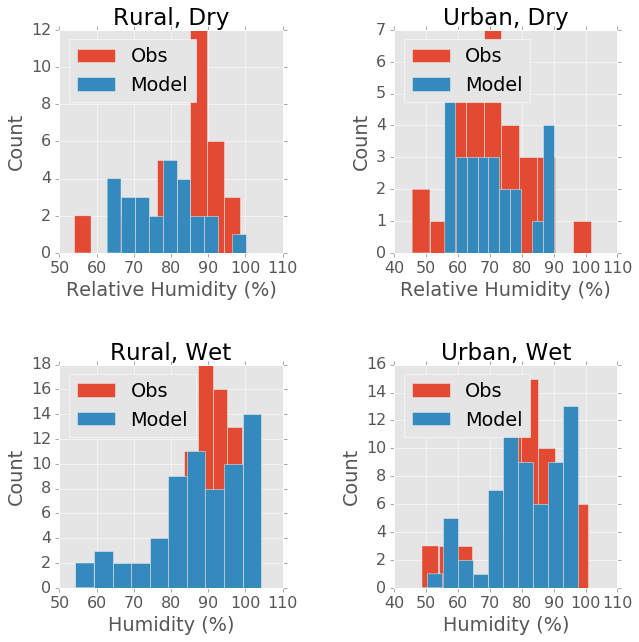

In [583]:
obs = rhDF[rural_sensor]
t = rural_df.loc[dom, idx['T2', 'mean']]
q = rural_df.loc[dom, idx['QVAPOR', 'mean']]
rh = relhum(1013, 273.15+t, q*1000.)*100

fig = plt.figure(figsize = [10,10])
ax = plt.subplot(2,2,1)
obs[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Obs')
rh[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Model')
plt.title('Rural, Dry')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Count')
plt.legend(loc=2)

ax = plt.subplot(2,2,3)
obs[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Obs')
rh[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Model')
plt.title('Rural, Wet')
plt.xlabel('Humidity (%)')
plt.ylabel('Count')
plt.legend(loc=2)

obs = rhDF[urban_sensor]
t = urban_df.loc[dom, idx['T2', 'mean']]
q = urban_df.loc[dom, idx['QVAPOR', 'mean']]
rh = relhum(1013, 273.15+t, q*1000.)*100
ax = plt.subplot(2,2,2)
obs[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Obs')
rh[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Model')
plt.title('Urban, Dry')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Count')
plt.legend(loc=2)
ax = plt.subplot(2,2,4)
obs[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Obs')
rh[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Model')
plt.title('Urban, Wet')
plt.xlabel('Humidity (%)')
plt.ylabel('Count')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.legend(loc=2)

(0, 16)

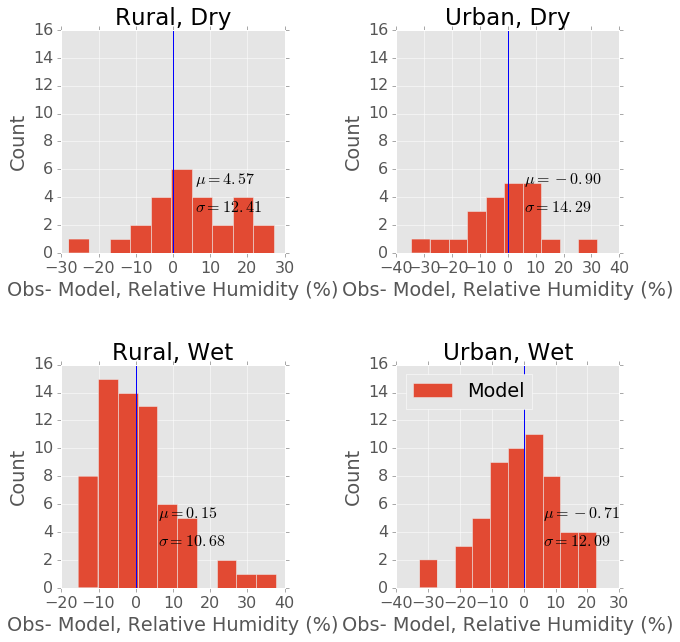

In [586]:
obs = rhDF[rural_sensor]
t = rural_df.loc[dom, idx['T2', 'mean']]
q = rural_df.loc[dom, idx['QVAPOR', 'mean']]
rh = relhum(1013, 273.15+t, q*1000.)*100

fig = plt.figure(figsize = [10,10])
ax = plt.subplot(2,2,1)
diff = obs[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)].subtract(rh[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)])
diff.hist()
plt.title('Rural, Dry')
plt.xlabel('Obs- Model, Relative Humidity (%)')
plt.ylabel('Count')
plt.axvline(0)
plt.text(6,5, "$\mu = %2.2f $"%(diff).mean())
plt.text(6,3, "$\sigma = %2.2f $"%(diff).std())
plt.ylim([0,16])

ax = plt.subplot(2,2,3)
diff = obs[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].subtract(rh[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)])
diff.hist()
plt.title('Rural, Wet')
plt.xlabel('Obs- Model, Relative Humidity (%)')
plt.ylabel('Count')
plt.legend(loc=2)
plt.axvline(0)
plt.text(6,5, "$\mu = %2.2f $"%(diff).mean())
plt.text(6,3, "$\sigma = %2.2f $"%(diff).std())
plt.ylim([0,16])

obs = rhDF[urban_sensor]
t = urban_df.loc[dom, idx['T2', 'mean']]
q = urban_df.loc[dom, idx['QVAPOR', 'mean']]
rh = relhum(1013, 273.15+t, q*1000.)*100
ax = plt.subplot(2,2,2)
diff = obs[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)].subtract(rh[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)])
diff.hist()
plt.title('Urban, Dry')
plt.xlabel('Obs- Model, Relative Humidity (%)')
plt.ylabel('Count')
plt.legend(loc=2)
plt.axvline(0)
plt.text(6,5, "$\mu = %2.2f $"%(diff).mean())
plt.text(6,3, "$\sigma = %2.2f $"%(diff).std())
plt.ylim([0,16])

ax = plt.subplot(2,2,4)
diff = obs[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].subtract(rh[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)])
diff.hist(label = 'Model')
plt.title('Urban, Wet')
plt.xlabel('Obs- Model, Relative Humidity (%)')
plt.ylabel('Count')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.legend(loc=2)
plt.axvline(0)
plt.text(6,5, "$\mu = %2.2f $"%(diff).mean())
plt.text(6,3, "$\sigma = %2.2f $"%(diff).std())
plt.ylim([0,16])

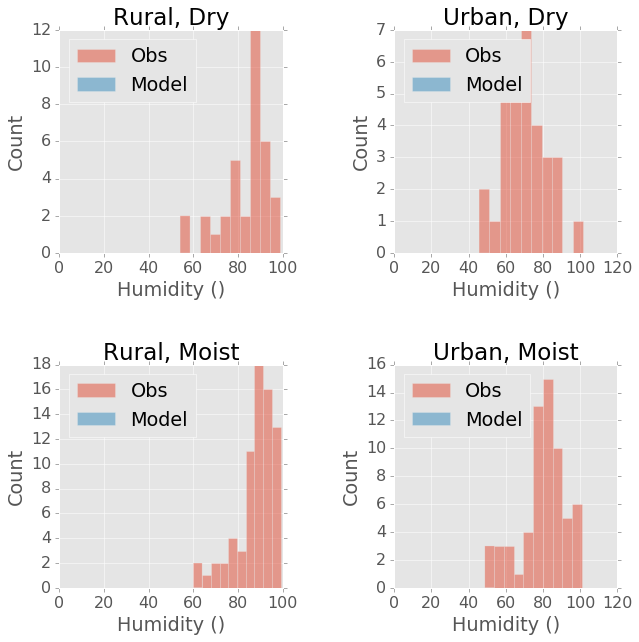

In [481]:
# histogram of Tu moist, Tu dry, Tr moist, Tr dry 
# Tr dry
# obs
urban_sensor = 97
var = 'QVAPOR'
fig = plt.figure(figsize = [10,10])
ax = plt.subplot(2,2,1)
rhDF[rural_sensor].loc[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Obs', alpha = .5)
t = rural_df.loc[dom, idx['T2', 'mean']][rural_df.loc[dom, idx[var, 'mean']].index.hour ==hr][syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)]
q = rural_df.loc[dom, idx['QVAPOR', 'mean']][rural_df.loc[dom, idx[var, 'mean']].index.hour ==hr][syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)]
rh = relhum(1013, 273.15+t, q*1000.)*100
rh.hist(label = 'Model', alpha = .5)
plt.legend(loc=2)
plt.title('Rural, Dry')
plt.xlabel('Humidity ()')
plt.ylabel('Count')
#plt.xlim([8,30])

ax = plt.subplot(2,2,2)
rhDF[urban_sensor].loc[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Obs', alpha = .5)
urban_df.loc[dom, idx[var, 'mean']][urban_df.loc[dom, idx[var, 'mean']].index.hour ==hr][syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Model', alpha = .5)
plt.legend(loc=2)
plt.title('Urban, Dry')
plt.xlabel('Humidity ()')
plt.ylabel('Count')
#plt.xlim([8,30])


ax = plt.subplot(2,2,3)
rhDF[rural_sensor].loc[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Obs', alpha = .5)
rural_df.loc[dom, idx[var, 'mean']][rural_df.loc[dom, idx[var, 'mean']].index.hour ==hr][syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Model', alpha = .5)
plt.legend(loc=2)
plt.title('Rural, Moist')
plt.xlabel('Humidity ()')
plt.ylabel('Count')
#plt.xlim([8,30])

ax = plt.subplot(2,2,4)
rhDF[urban_sensor].loc[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Obs', alpha = .5)
urban_df.loc[dom, idx[var, 'mean']][urban_df.loc[dom, idx[var, 'mean']].index.hour ==hr][syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Model', alpha = .5)
plt.legend(loc=2)
plt.title('Urban, Moist')
plt.xlabel('Humidity ()')
plt.ylabel('Count')
#plt.xlim([8,30])
plt.subplots_adjust(wspace=0.5, hspace=0.5);


# Feb 19- look at model performance on dry days versus moist 

In [376]:
exp = 'UCM+SST'
urban_df = pd.read_csv('data/urban_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
urban_df['T2', 'mean'] = urban_df['T2', 'mean'].subtract(273.15)
urban_df.index = urban_df.index.set_levels([urban_df.index.levels[0], pd.to_datetime(urban_df.index.levels[1])])

rural_df = pd.read_csv('data/rural_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
rural_df['T2', 'mean'] = rural_df['T2', 'mean'].subtract(273.15)
rural_df.index = rural_df.index.set_levels([rural_df.index.levels[0], pd.to_datetime(rural_df.index.levels[1])])


uhi_df = pd.read_csv('data/uhi_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
uhi_df.index = uhi_df.index.set_levels([uhi_df.index.levels[0], pd.to_datetime(uhi_df.index.levels[1])])

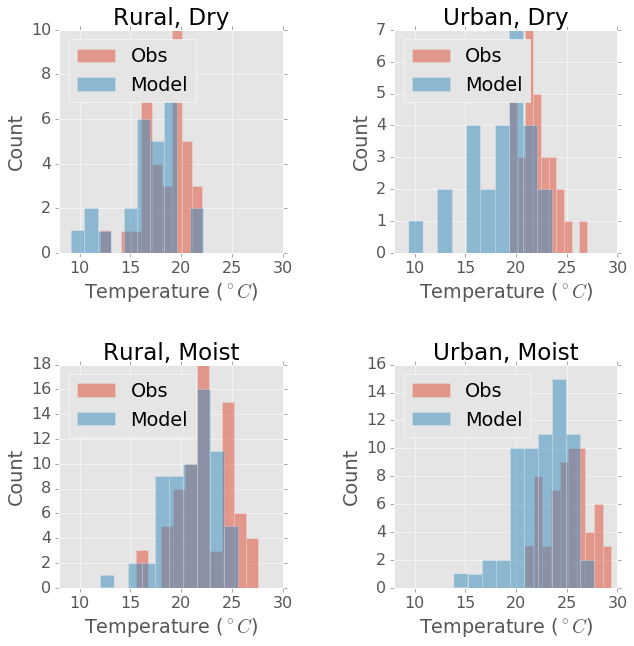

In [434]:
# histogram of Tu moist, Tu dry, Tr moist, Tr dry 
# Tr dry
# obs
fig = plt.figure(figsize = [10,10])
ax = plt.subplot(2,2,1)
tempDF[rural_sensor].loc[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Obs', alpha = .5)
rural_df.loc[dom, idx['T2', 'mean']][rural_df.loc[dom, idx['T2', 'mean']].index.hour ==hr][syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Model', alpha = .5)
plt.legend(loc=2)
plt.title('Rural, Dry')
plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('Count')
plt.xlim([8,30])

ax = plt.subplot(2,2,2)
tempDF[urban_sensor].loc[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Obs', alpha = .5)
urban_df.loc[dom, idx['T2', 'mean']][urban_df.loc[dom, idx['T2', 'mean']].index.hour ==hr][syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Model', alpha = .5)
plt.legend(loc=2)
plt.title('Urban, Dry')
plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('Count')
plt.xlim([8,30])


ax = plt.subplot(2,2,3)
tempDF[rural_sensor].loc[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Obs', alpha = .5)
rural_df.loc[dom, idx['T2', 'mean']][rural_df.loc[dom, idx['T2', 'mean']].index.hour ==hr][syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Model', alpha = .5)
plt.legend(loc=2)
plt.title('Rural, Moist')
plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('Count')
plt.xlim([8,30])

ax = plt.subplot(2,2,4)
tempDF[urban_sensor].loc[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Obs', alpha = .5)
urban_df.loc[dom, idx['T2', 'mean']][urban_df.loc[dom, idx['T2', 'mean']].index.hour ==hr][syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)].hist(label = 'Model', alpha = .5)
plt.legend(loc=2)
plt.title('Urban, Moist')
plt.xlabel('Temperature ($^\circ C$)')
plt.ylabel('Count')
plt.xlim([8,30])
plt.subplots_adjust(wspace=0.5, hspace=0.5);


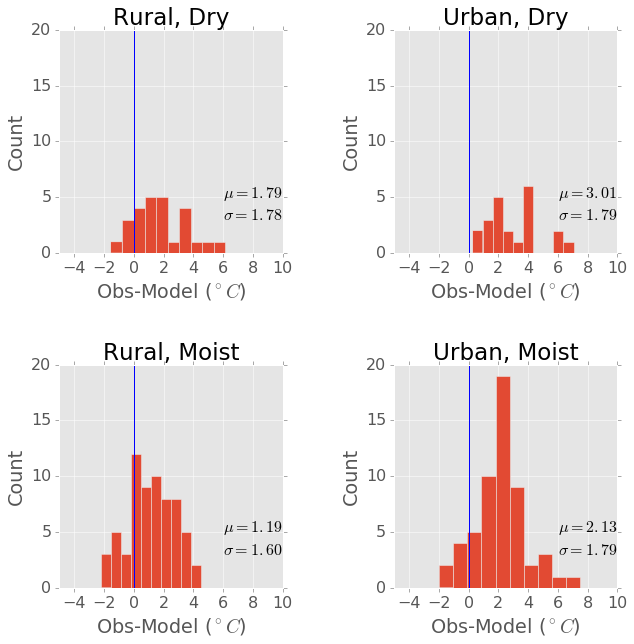

In [437]:
fig = plt.figure(figsize = [10,10])
ax = plt.subplot(2,2,1)
obs = tempDF[rural_sensor].loc[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)]
model = rural_df.loc[dom, idx['T2', 'mean']][rural_df.loc[dom, idx['T2', 'mean']].index.hour ==hr][syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)]
(obs-model).hist()
plt.xlabel('Obs-Model ($^\circ C$)')
plt.ylabel('Count')
plt.xlim([-5,10])
plt.text(6,5, "$\mu = %2.2f $"%(obs-model).mean())
plt.axvline(0)
plt.ylim([0,20])
plt.text(6,3, "$\sigma = %2.2f $"%(obs-model).std())

plt.title('Rural, Dry')

ax = plt.subplot(2,2,2)
obs = tempDF[urban_sensor].loc[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)]
model = urban_df.loc[dom, idx['T2', 'mean']][urban_df.loc[dom, idx['T2', 'mean']].index.hour ==hr][syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)]
(obs-model).hist()
plt.xlabel('Obs-Model ($^\circ C$)')
plt.ylabel('Count')
plt.xlim([-5,10])
plt.text(6,5, "$\mu = %2.2f $"%(obs-model).mean())
plt.axvline(0)
plt.ylim([0,20])
plt.text(6,3, "$\sigma = %2.2f $"%(obs-model).std())

plt.title('Urban, Dry')

ax = plt.subplot(2,2,3)
obs = tempDF[rural_sensor].loc[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)]
model = rural_df.loc[dom, idx['T2', 'mean']][rural_df.loc[dom, idx['T2', 'mean']].index.hour ==hr][syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)]
(obs-model).hist()
plt.xlabel('Obs-Model ($^\circ C$)')
plt.ylabel('Count')
plt.xlim([-5,10])
plt.ylim([0,20])
plt.text(6,3, "$\sigma = %2.2f $"%(obs-model).std())

plt.axvline(0)
plt.text(6,5, "$\mu = %2.2f $"%(obs-model).mean())
plt.title('Rural, Moist')

ax = plt.subplot(2,2,4)
obs = tempDF[urban_sensor].loc[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)]
model = urban_df.loc[dom, idx['T2', 'mean']][urban_df.loc[dom, idx['T2', 'mean']].index.hour ==hr][syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)]
(obs-model).hist()
plt.xlabel('Obs-Model ($^\circ C$)')
plt.ylabel('Count')
plt.xlim([-5,10])
plt.ylim([0,20])
plt.axvline(0)
plt.text(6,5, "$\mu = %2.2f $"%(obs-model).mean())
plt.text(6,3, "$\sigma = %2.2f $"%(obs-model).std())
plt.title('Urban, Moist')

plt.subplots_adjust(wspace=0.5, hspace=0.5);

In [442]:
# for comparison, overall obs-model 
# rural 
obs = tempDF[rural_sensor]#.loc[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)]
model = rural_df.loc[dom, idx['T2', 'mean']][rural_df.loc[dom, idx['T2', 'mean']].index.hour ==hr]#[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)]
#rural_err = ((obs-model)**2).mean()
rural_err = ((obs-model)).mean()
#urban 
obs = tempDF[urban_sensor]#.loc[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)]
model = urban_df.loc[dom, idx['T2', 'mean']][urban_df.loc[dom, idx['T2', 'mean']].index.hour ==hr]#[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)]
#urban_err = ((obs-model)**2).mean()
urban_err = ((obs-model)).mean()
print("Rural error is : %2.2f, urban error is : %2.2f"%(rural_err, urban_err))

Rural error is : 1.31, urban error is : 2.38


# Conclusion 
We've seen that dry days are cooling off too much. If we compare the observations to the model for urban and rural on dry and moist days, we see: 
- model does better for rural than urban areas
- model is colder than observations
- mean error lower for moist days than for dry days 

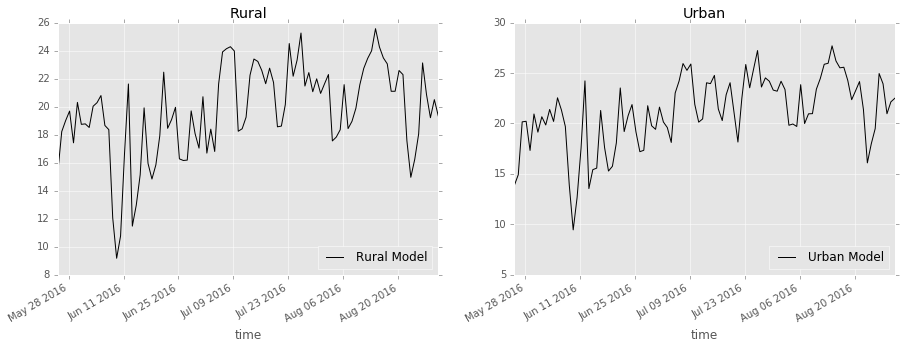

In [393]:
hr =6
fig = plt.figure(figsize = [15,5])
ax = plt.subplot(1,2,1)
#tempDF[tempDF.index.hour ==hr][rural_sensor].dropna().plot()
#tempDF[tempDF.index.hour ==hr][rural_sensor].plot(label='Rural Obs', linestyle = '--', color = 'k')
rural_df.loc[dom, idx['T2', 'mean']][rural_df.loc[dom, idx['T2', 'mean']].index.hour ==hr].plot(label='Rural Model', color = 'k')
plt.title('Rural')
plt.legend(loc = 4)
ax = plt.subplot(1,2,2)
#tempDF[tempDF.index.hour ==hr][urban_sensor].plot(label='Urban Obs', linestyle = '--', color = 'k')
urban_df.loc[dom, idx['T2', 'mean']][urban_df.loc[dom, idx['T2', 'mean']].index.hour ==hr].plot(label='Urban Model', color = 'k')
plt.title('Urban')
plt.legend(loc = 4)

# Feb 15- look at how UHI changes over time for each domain
Now that we know that UCM + SSTs has the highest UHI, does it obey the relationship we want? 

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:49: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stabl

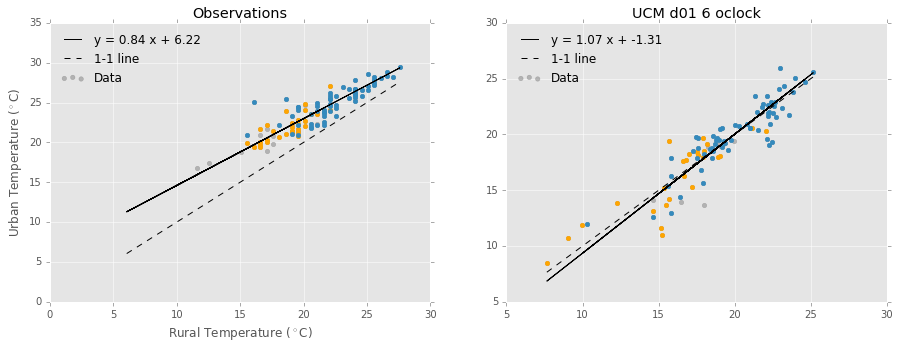

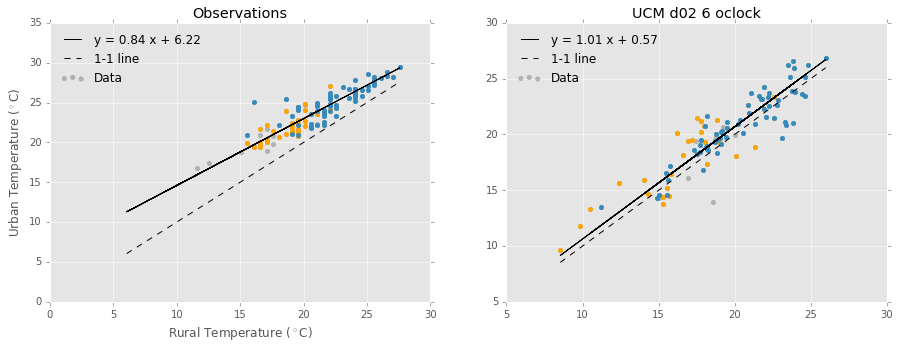

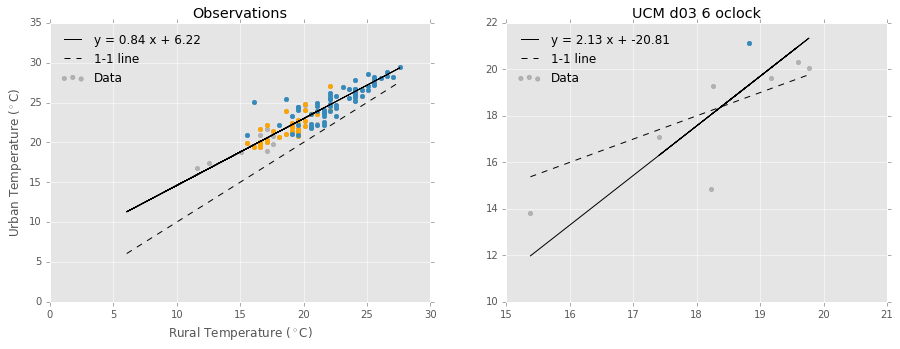

In [374]:
exp = 'UCM'
urban_df = pd.read_csv('data/urban_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
urban_df['T2', 'mean'] = urban_df['T2', 'mean'].subtract(273.15)
urban_df.index = urban_df.index.set_levels([urban_df.index.levels[0], pd.to_datetime(urban_df.index.levels[1])])

rural_df = pd.read_csv('data/rural_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
rural_df['T2', 'mean'] = rural_df['T2', 'mean'].subtract(273.15)
rural_df.index = rural_df.index.set_levels([rural_df.index.levels[0], pd.to_datetime(rural_df.index.levels[1])])


uhi_df = pd.read_csv('data/uhi_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
uhi_df.index = uhi_df.index.set_levels([uhi_df.index.levels[0], pd.to_datetime(uhi_df.index.levels[1])])
dom = 'd02'
dry_color = 'orange'
moist_color = u'#348ABD'
for dom in ['d01', 'd02', 'd03']: 
    fig = plt.figure(figsize = [15,5])
    ax = plt.subplot(1,2,1)
    hour = 6
    easy_scatter_tls(tempDF[rural_sensor][tempDF.index.hour ==hour ] , tempDF[urban_sensor][tempDF.index.hour ==hour ],
                 'Observations', 
                 'Rural Temperature ($^\circ $C)', 'Urban Temperature ($^\circ $C)')
    # plot dry 
    plt.scatter(tempDF[rural_sensor].loc[syn[syn <=3].index + pd.Timedelta('06:00:00')], 
               tempDF[urban_sensor].loc[syn[syn <=3].index + pd.Timedelta('06:00:00')], color = dry_color)
    # plot moist
    plt.scatter(tempDF[rural_sensor].loc[syn[syn >3].index + pd.Timedelta('06:00:00')], 
              tempDF[urban_sensor].loc[syn[syn >3].index + pd.Timedelta('06:00:00')], color = moist_color)

    ax = plt.subplot(1,2,2)
    hr = 6
    x = rural_df.loc[dom, idx['T2', 'mean']][rural_df.loc[dom, idx['T2', 'mean']].index.hour ==hr]
    y = urban_df.loc[dom, idx['T2', 'mean']][urban_df.loc[dom, idx['T2', 'mean']].index.hour ==hr]
    easy_scatter_tls(x,y,'%s %s %s oclock'%(exp, dom, hr))
    # plot dry 
    plt.scatter(x.loc[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)], 
                y.loc[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)], color = dry_color)
    # plot moist
    plt.scatter(x.loc[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)], 
                y.loc[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)], color = moist_color)


/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:49: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stabl

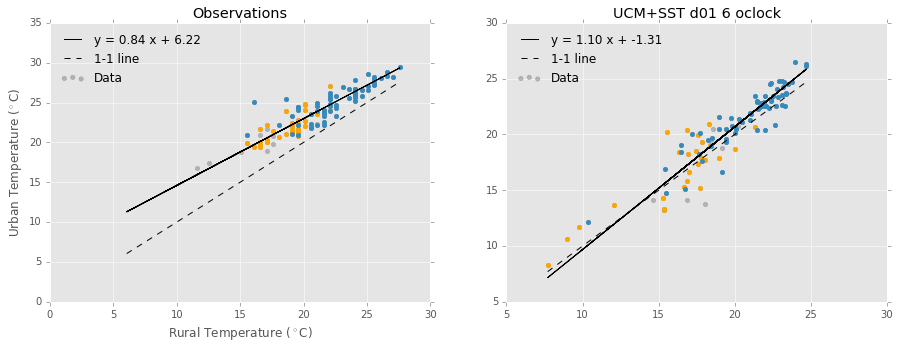

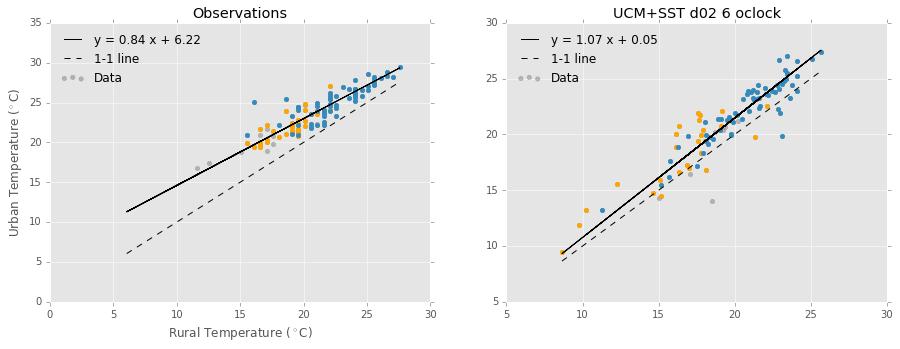

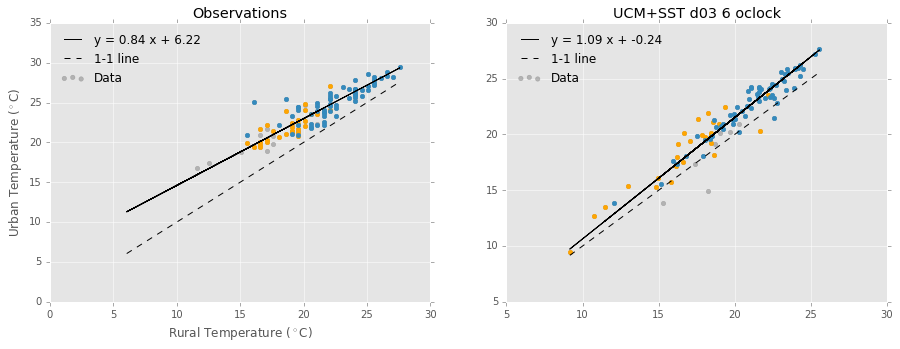

In [373]:
exp = 'UCM+SST'
urban_df = pd.read_csv('data/urban_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
urban_df['T2', 'mean'] = urban_df['T2', 'mean'].subtract(273.15)
urban_df.index = urban_df.index.set_levels([urban_df.index.levels[0], pd.to_datetime(urban_df.index.levels[1])])

rural_df = pd.read_csv('data/rural_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
rural_df['T2', 'mean'] = rural_df['T2', 'mean'].subtract(273.15)
rural_df.index = rural_df.index.set_levels([rural_df.index.levels[0], pd.to_datetime(rural_df.index.levels[1])])


uhi_df = pd.read_csv('data/uhi_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
uhi_df.index = uhi_df.index.set_levels([uhi_df.index.levels[0], pd.to_datetime(uhi_df.index.levels[1])])
dom = 'd02'
dry_color = 'orange'
moist_color = u'#348ABD'
for dom in ['d01', 'd02', 'd03']: 
    fig = plt.figure(figsize = [15,5])
    ax = plt.subplot(1,2,1)
    hour = 6
    easy_scatter_tls(tempDF[rural_sensor][tempDF.index.hour ==hour ] , tempDF[urban_sensor][tempDF.index.hour ==hour ],
                 'Observations', 
                 'Rural Temperature ($^\circ $C)', 'Urban Temperature ($^\circ $C)')
    # plot dry 
    plt.scatter(tempDF[rural_sensor].loc[syn[syn <=3].index + pd.Timedelta('06:00:00')], 
               tempDF[urban_sensor].loc[syn[syn <=3].index + pd.Timedelta('06:00:00')], color = dry_color)
    # plot moist
    plt.scatter(tempDF[rural_sensor].loc[syn[syn >3].index + pd.Timedelta('06:00:00')], 
              tempDF[urban_sensor].loc[syn[syn >3].index + pd.Timedelta('06:00:00')], color = moist_color)

    ax = plt.subplot(1,2,2)
    hr = 6
    x = rural_df.loc[dom, idx['T2', 'mean']][rural_df.loc[dom, idx['T2', 'mean']].index.hour ==hr]
    y = urban_df.loc[dom, idx['T2', 'mean']][urban_df.loc[dom, idx['T2', 'mean']].index.hour ==hr]
    easy_scatter_tls(x,y,'%s %s %s oclock'%(exp, dom, hr))
    # plot dry 
    plt.scatter(x.loc[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)], 
                y.loc[syn[syn <=3].index + pd.Timedelta('0%s:00:00'%hr)], color = dry_color)
    # plot moist
    plt.scatter(x.loc[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)], 
                y.loc[syn[syn >3].index + pd.Timedelta('0%s:00:00'%hr)], color = moist_color)


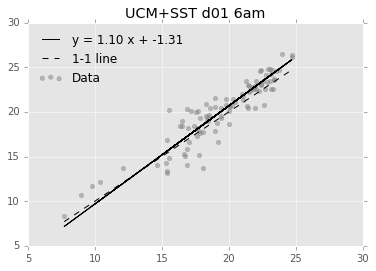

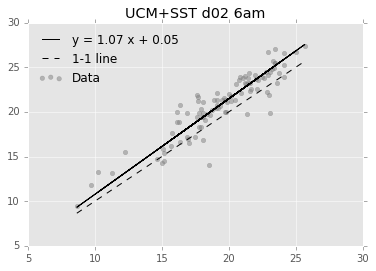

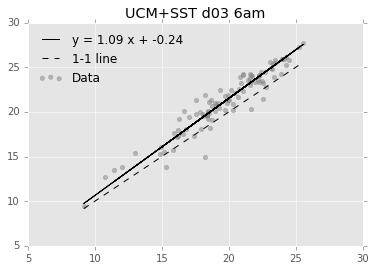

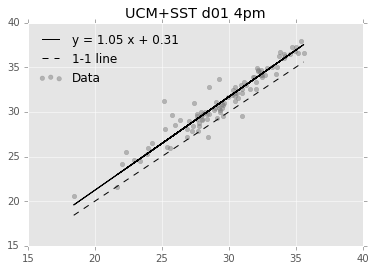

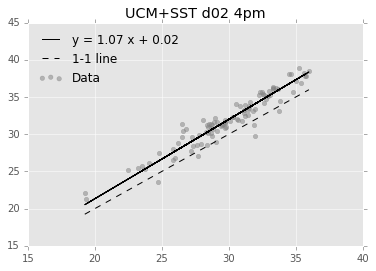

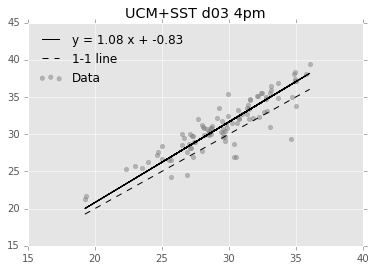

In [375]:
## read in UCM+SSTs 
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
exp = 'UCM+SST'
urban_df = pd.read_csv('data/urban_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
urban_df['T2', 'mean'] = urban_df['T2', 'mean'].subtract(273.15)
urban_df.index = urban_df.index.set_levels([urban_df.index.levels[0], pd.to_datetime(urban_df.index.levels[1])])

rural_df = pd.read_csv('data/rural_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
rural_df['T2', 'mean'] = rural_df['T2', 'mean'].subtract(273.15)
rural_df.index = rural_df.index.set_levels([rural_df.index.levels[0], pd.to_datetime(rural_df.index.levels[1])])


uhi_df = pd.read_csv('data/uhi_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
uhi_df.index = uhi_df.index.set_levels([uhi_df.index.levels[0], pd.to_datetime(uhi_df.index.levels[1])])

for dom in ['d01', 'd02', 'd03'] : 
    plt.figure()
    easy_scatter_tls(rural_df.loc[dom, idx['T2', 'mean']][rural_df.loc[dom, idx['T2', 'mean']].index.hour ==6], 
                    urban_df.loc[dom, idx['T2', 'mean']][urban_df.loc[dom, idx['T2', 'mean']].index.hour ==6],
                 '%s %s 6am'%(exp, dom))
    
for dom in ['d01', 'd02', 'd03'] : 
    plt.figure()
    easy_scatter_tls(rural_df.loc[dom, idx['T2', 'mean']][rural_df.loc[dom, idx['T2', 'mean']].index.hour ==16], 
                    urban_df.loc[dom, idx['T2', 'mean']][urban_df.loc[dom, idx['T2', 'mean']].index.hour ==16],
                 '%s %s 4pm'%(exp, dom))

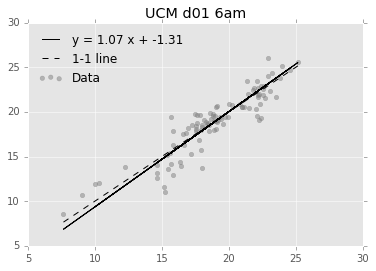

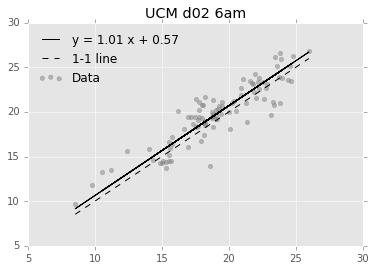

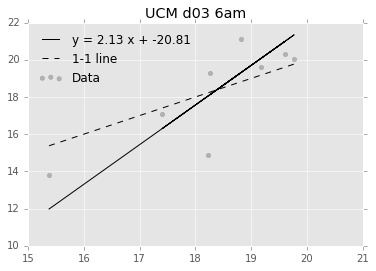

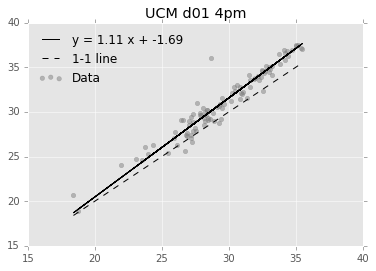

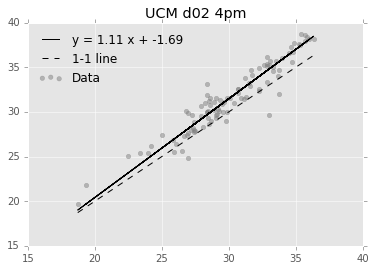

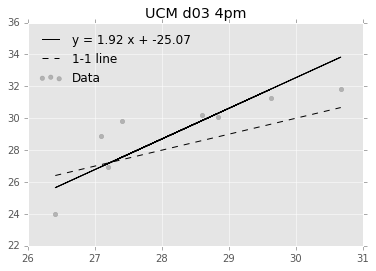

In [283]:
# read in UCM+SSTs 
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
exp = 'UCM'
urban_df = pd.read_csv('data/urban_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
urban_df['T2', 'mean'] = urban_df['T2', 'mean'].subtract(273.15)
urban_df.index = urban_df.index.set_levels([urban_df.index.levels[0], pd.to_datetime(urban_df.index.levels[1])])

rural_df = pd.read_csv('data/rural_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
rural_df['T2', 'mean'] = rural_df['T2', 'mean'].subtract(273.15)
rural_df.index = rural_df.index.set_levels([rural_df.index.levels[0], pd.to_datetime(rural_df.index.levels[1])])


uhi_df = pd.read_csv('data/uhi_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
uhi_df.index = uhi_df.index.set_levels([uhi_df.index.levels[0], pd.to_datetime(uhi_df.index.levels[1])])

for dom in ['d01', 'd02', 'd03'] : 
    plt.figure()
    easy_scatter_tls(rural_df.loc[dom, idx['T2', 'mean']][rural_df.loc[dom, idx['T2', 'mean']].index.hour ==6], 
                    urban_df.loc[dom, idx['T2', 'mean']][urban_df.loc[dom, idx['T2', 'mean']].index.hour ==6],
                 '%s %s 6am'%(exp, dom))
    
for dom in ['d01', 'd02', 'd03'] : 
    plt.figure()
    easy_scatter_tls(rural_df.loc[dom, idx['T2', 'mean']][rural_df.loc[dom, idx['T2', 'mean']].index.hour ==16], 
                    urban_df.loc[dom, idx['T2', 'mean']][urban_df.loc[dom, idx['T2', 'mean']].index.hour ==16],
                 '%s %s 4pm'%(exp, dom))

# Feb 7: Look at how temperature, UHI varies over time 
## taking into account spatial variability, for different spatial resolution
Look at temp (tu, tr, t1u, t1r, t2u, t2r, T2m_u, T2m_r, TSK...) and DT at 6am, 4pm
-make urban/rural a multi index column? 

In [3]:
urban = 86 #97 # science center
rural = 4 #68 # darryn's house
analysis_points = meta.loc[[urban,rural]][['location:Longitude', 'location:Latitude']]
analysis_points = meta.loc[[urban,rural]][['location:Longitude', 'location:Latitude']]
analysis_points.index = ['urban', 'rural']
# pick a random rural point for analysis
analysis_points.loc['urban', 'location:Longitude'] = -76.588325
analysis_points.loc['urban', 'location:Latitude']  = 39.289591
analysis_points.loc['rural', 'location:Longitude'] = -76.752754
analysis_points.loc['rural', 'location:Latitude']  = 39.637964

In [15]:
import os 
fpath = os.getenv("HOME")+'/mountpoint/wrf/out/'
exp = 'UCM+SST'
dom = 'd03'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
hours = [6,16]
hr = 6
var = 'T2'
cols = hours#['6am', '4pm']#, 'UHI_max', 'UHI_min', 'date']
test_list = []
for file in files[hr+4:72:24]:
        test_list.append(Dataset(file))
df = getvar(test_list, varname = var, 
                      timeidx = wrf.ALL_TIMES, 
                      method = 'cat'
                   )

['/Users/annascott2/mountpoint/wrf/out/UCM+SST/d03/wrfout_d01_2016-05-25_00:00:00',
 '/Users/annascott2/mountpoint/wrf/out/UCM+SST/d03/wrfout_d01_2016-05-25_01:00:00',
 '/Users/annascott2/mountpoint/wrf/out/UCM+SST/d03/wrfout_d01_2016-05-25_02:00:00',
 '/Users/annascott2/mountpoint/wrf/out/UCM+SST/d03/wrfout_d01_2016-05-25_03:00:00',
 '/Users/annascott2/mountpoint/wrf/out/UCM+SST/d03/wrfout_d01_2016-05-25_04:00:00',
 '/Users/annascott2/mountpoint/wrf/out/UCM+SST/d03/wrfout_d01_2016-05-25_05:00:00',
 '/Users/annascott2/mountpoint/wrf/out/UCM+SST/d03/wrfout_d01_2016-05-25_06:00:00',
 '/Users/annascott2/mountpoint/wrf/out/UCM+SST/d03/wrfout_d01_2016-05-25_07:00:00',
 '/Users/annascott2/mountpoint/wrf/out/UCM+SST/d03/wrfout_d01_2016-05-25_08:00:00',
 '/Users/annascott2/mountpoint/wrf/out/UCM+SST/d03/wrfout_d01_2016-05-25_09:00:00',
 '/Users/annascott2/mountpoint/wrf/out/UCM+SST/d03/wrfout_d01_2016-05-25_10:00:00',
 '/Users/annascott2/mountpoint/wrf/out/UCM+SST/d03/wrfout_d01_2016-05-25_11:

In [50]:
pts_u = wrf.ll_to_xy(Dataset(files[-1]),analysis_points['location:Latitude']['urban'],
                     analysis_points['location:Longitude']['urban'])
urban = df.isel(west_east = range(pts_u.values[0]-1, pts_u.values[0]+2), 
       south_north = range(pts_u.values[1]-1, pts_u.values[1]+2))
pts_r = wrf.ll_to_xy(Dataset(files[-1]),analysis_points['location:Latitude']['rural'],
                     analysis_points['location:Longitude']['rural'])
rural = df.isel(west_east = range(pts_r.values[0]-1, pts_r.values[0]+2), 
       south_north = range(pts_r.values[1]-1, pts_r.values[1]+2))

urban_mean = urban.mean(axis=2).mean(axis=1)
urban_std = urban.values.reshape(urban.values.shape[0], np.product(urban.values.shape[1:])).std(axis=1)
rural_mean = rural.mean(axis=2).mean(axis=1)
rural_std = rural.values.reshape(urban.values.shape[0], np.product(urban.values.shape[1:])).std(axis=1)

In [100]:
analysis_points

location:Longitude  location:Latitude
urban          -76.588325          39.289591
rural          -76.752754          39.637964

In [13]:
# make dataframe

variables = ['T2', 'TSK']
exp = 'UCM+SST'
dom = 'd03'
fpath = '/Users/ascott47/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
hours = [6,16]
cols = hours#['6am', '4pm']#, 'UHI_max', 'UHI_min', 'date']
for file in files[hr+4::24]:
        test_list.append(Dataset(file))
df = getvar(test_list, varname = var, 
                      timeidx = wrf.ALL_TIMES, 
                      method = 'cat'
                   )
df['Time'] = df['Time'] - pd.Timedelta('04:00:00')
iterables = [['d01', 'd02','d03'],df.Time.values]
col_iterables = [hours, variables]
urban_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time']), 
                     columns=pd.MultiIndex.from_product(col_iterables, names = ['hour', 'variable']), dtype= float32)
rural_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time']), 
                     columns=pd.MultiIndex.from_product(col_iterables, names = ['hour', 'variable']))
# urban_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time', 'variables']),
#                      columns=cols)
# rural_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time', 'variables']),
#                      columns=cols)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/inspect.py", line 1048, in getinnerframes
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/inspect.py", line 1008, in getframeinfo
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/inspect.py", line 453, in getsourcefile
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/inspect.py", line 482, in getmodule
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/inspect.py", line 466, in getabsfile
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/posixpath.py", line 364, in 

IndexError: string index out of range

In [5]:
## run in ipython

variables = ['T2', 'TSK']
#exp = 'UCM+SST'
exp = 'UCM'

dom = 'd03'
fpath = '/Users/ascott47/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))

idx = pd.IndexSlice
for exp in ['UCM', 'UCM+SST']:
    for dom in ['d01', 'd02', 'd03'] :  
        hours = [6,16]
        for hr in hours : 
            files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
            pts = wrf.ll_to_xy(Dataset(files[-1]),analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            counter = 0
            test_list = []
            for file in files[hr+4::24]:
                test_list.append(Dataset(file))
                counter = counter+1

            for var in variables:     
                df = getvar(test_list, varname = var, 
                              timeidx = wrf.ALL_TIMES, 
                              method = 'cat'
                           )

                df['Time'] = df['Time'] - pd.Timedelta('04:00:00')
                urban = df.isel(west_east = pts.values[0], south_north = pts.values[1])[:,0,0]
                rural = df.isel(west_east = pts.values[0], south_north = pts.values[1])[:,1,1]
                urban_df.loc[dom, idx[hr, var]] = urban.to_pandas().values
                rural_df.loc[dom, idx[hr, var]] = rural.to_pandas().values

                df.close()
                del df
            del test_list
urban_df.to_csv('data/urban_%s.csv'%exp)
rural_df.to_csv('data/rural_%s.csv'%exp)

NameError: name 'analysis_points' is not defined

In [ ]:
# run in python, uses multiple points 
## run in ipython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial
import os 

from netCDF4 import Dataset
from wrf import getvar
import wrf
from wrf import ALL_TIMES
analysis_points = pd.DataFrame(index = [u'urban', u'rural'], columns = [u'location:Longitude', u'location:Latitude'])
analysis_points.loc['urban', 'location:Longitude'] = -76.588325
analysis_points.loc['urban', 'location:Latitude']  = 39.289591
analysis_points.loc['rural', 'location:Longitude'] = -76.752754
analysis_points.loc['rural', 'location:Latitude']  = 39.637964

exp = 'UCM+SST'
dom = 'd03'
fpath = os.getenv("HOME")+'/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01_*'%(exp,dom))))
test_list = []
hr = 6
var = 'T2'
for file in files[10::24]: # 10 am UTC is 6am  local--> 6+4 =10, 16+4 = 20
        test_list.append(Dataset(file))

df = getvar(test_list, varname = var, 
                      timeidx = wrf.ALL_TIMES, 
                      method = 'cat'
                   )
df['Time'] = df['Time'] - pd.Timedelta('04:00:00')
times = np.sort(np.concatenate((df['Time'].values, df['Time'].values + pd.Timedelta(10, 'h')), axis=0))
iterables = [['d01', 'd02','d03'],times]
#hours = [6,16]
variables = ['T2', 'TSK']
col_iterables = [variables, ['mean', 'std']]

urban_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time']), 
                     columns=pd.MultiIndex.from_product(col_iterables, names = ['variable', 'stat']))
rural_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time']), 
                     columns=pd.MultiIndex.from_product(col_iterables, names = ['variable', 'stat']))
uhi_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time']), 
                     columns=pd.MultiIndex.from_product(col_iterables, names = ['variable', 'stat']))
idx = pd.IndexSlice
hours = [6,16]
for exp in ['UCM', 'UCM+SST']:
    for dom in ['d01', 'd02', 'd03'] :  
        for hr in hours : 
            files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
            pts_u = wrf.ll_to_xy(Dataset(files[-1]),analysis_points['location:Latitude']['urban'],
                                 analysis_points['location:Longitude']['urban'])
            pts_r = wrf.ll_to_xy(Dataset(files[-1]),analysis_points['location:Latitude']['rural'],
                                 analysis_points['location:Longitude']['rural'])
            counter = 0
            test_list = []
            for file in files[hr+4::24]:
                test_list.append(Dataset(file))
                counter = counter+1

            for var in variables:     
                df = getvar(test_list, varname = var, 
                              timeidx = wrf.ALL_TIMES, 
                              method = 'cat'
                           )

                df['Time'] = df['Time'] - pd.Timedelta('04:00:00')
                urban = df.isel(west_east = range(pts_u.values[0]-1, pts_u.values[0]+2), 
                                south_north = range(pts_u.values[1]-1, pts_u.values[1]+2))
                rural = df.isel(west_east = range(pts_r.values[0]-1, pts_r.values[0]+2), 
                                south_north = range(pts_r.values[1]-1, pts_r.values[1]+2))
                
                urban_df.loc[dom, idx[ var, 'mean']].loc[slice(urban.Time[0].values, urban.Time[-1].values)].iloc[::2] = urban.mean(axis=2).mean(axis=1)
                rural_df.loc[dom, idx[ var, 'mean']].loc[slice(rural.Time[0].values, urban.Time[-1].values)].iloc[::2] = rural.mean(axis=2).mean(axis=1)
                urban_df.loc[dom, idx[ var, 'std']].loc[slice(urban.Time[0].values, urban.Time[-1].values)].iloc[::2]  = urban.values.reshape(urban.values.shape[0], np.product(urban.values.shape[1:])).std(axis=1)
                rural_df.loc[dom, idx[ var, 'std']].loc[slice(rural.Time[0].values, urban.Time[-1].values)].iloc[::2]  = rural.values.reshape(urban.values.shape[0], np.product(urban.values.shape[1:])).std(axis=1)
                uhi_df.loc[dom, idx[ var, 'mean']].loc[slice(urban.Time[0].values, urban.Time[-1].values)].iloc[::2] = (urban-rural).mean(axis=2).mean(axis=1)
                uhi_df.loc[dom, idx[ var, 'std']].loc[slice(urban.Time[0].values, urban.Time[-1].values)].iloc[::2] = (urban-rural).values.reshape(urban.values.shape[0], np.product(urban.values.shape[1:])).std(axis=1)

                df.close()
                del df
            del test_list
    urban_df.to_csv('data/urban_%s.csv'%exp)
    rural_df.to_csv('data/rural_%s.csv'%exp)
    uhi_df.to_csv('data/uhi_%s.csv'%exp)

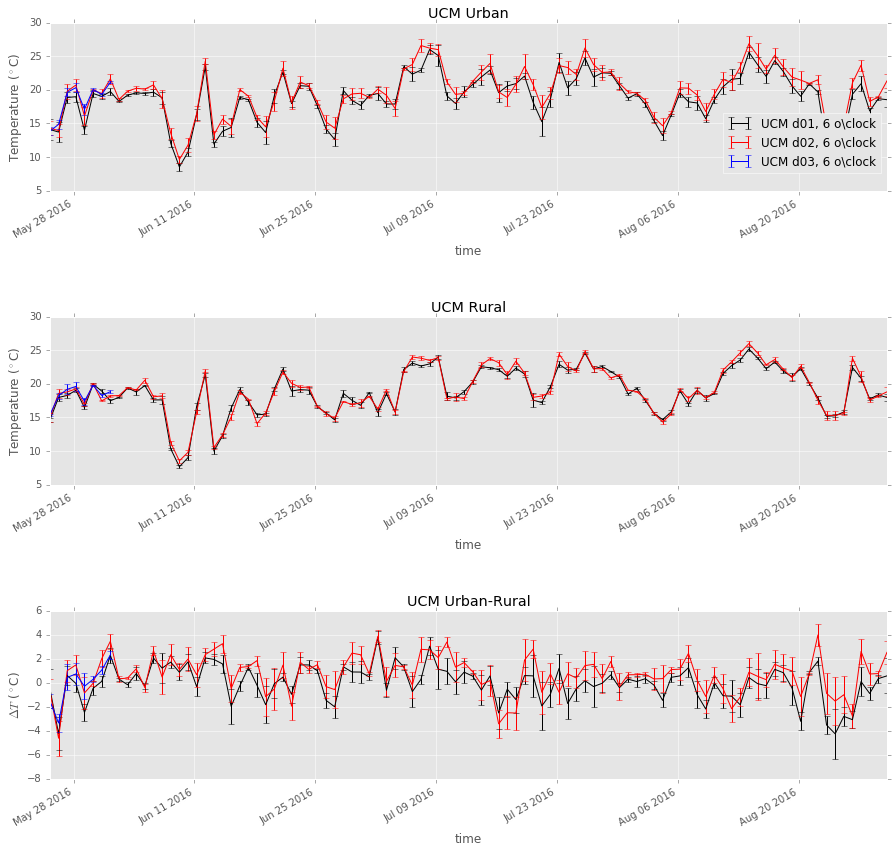

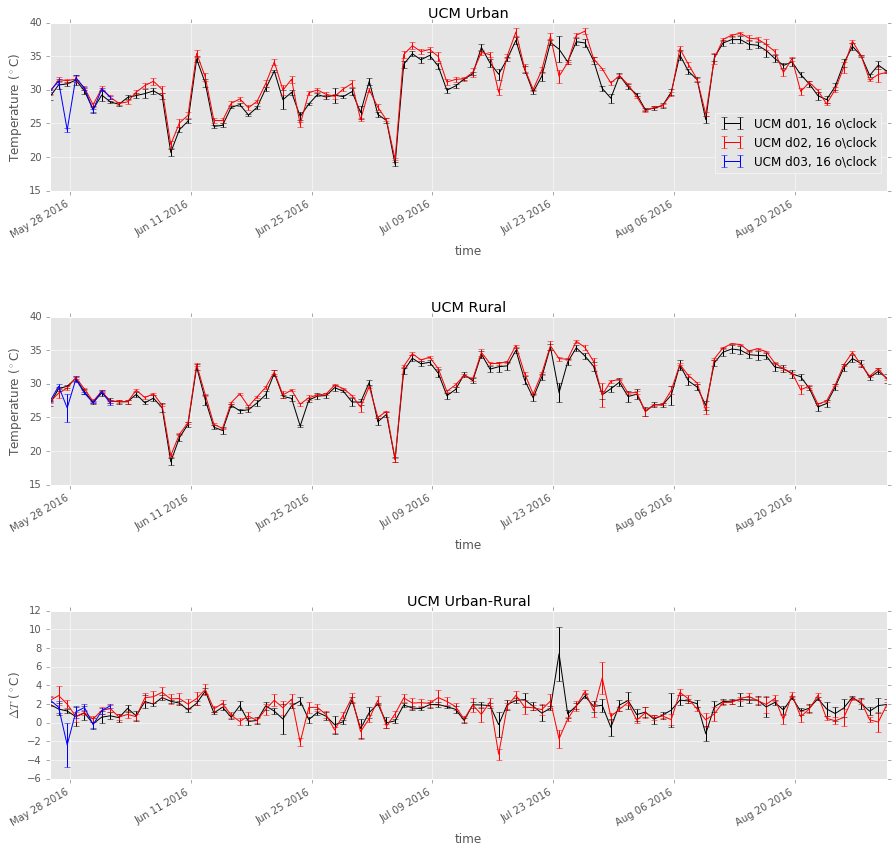

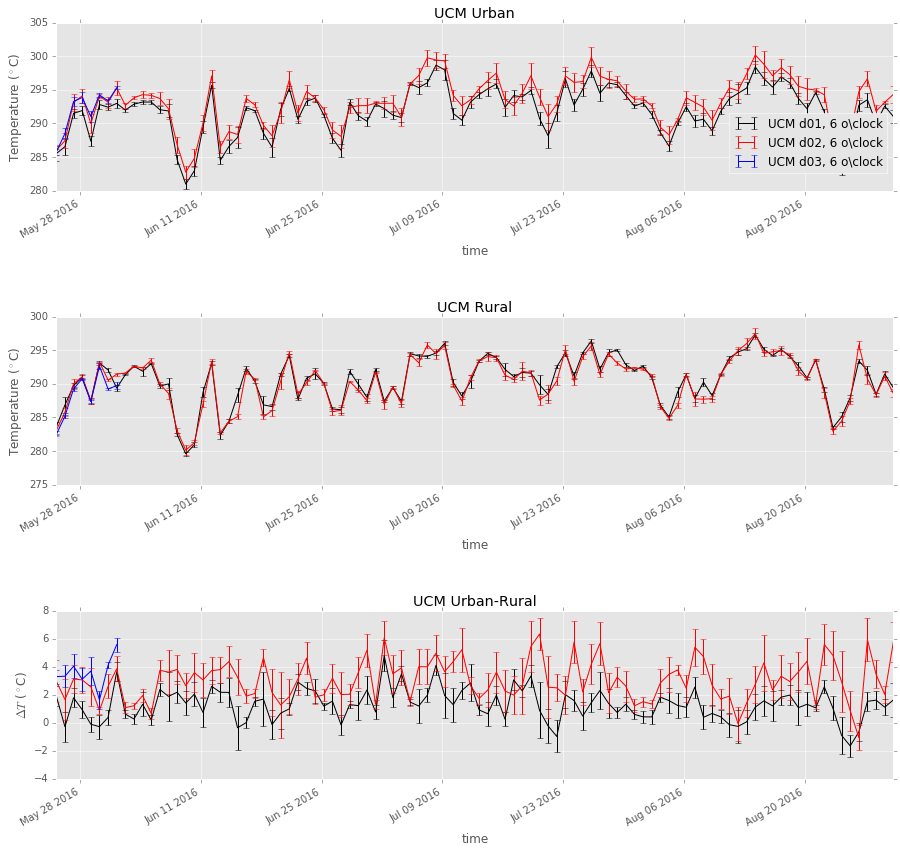

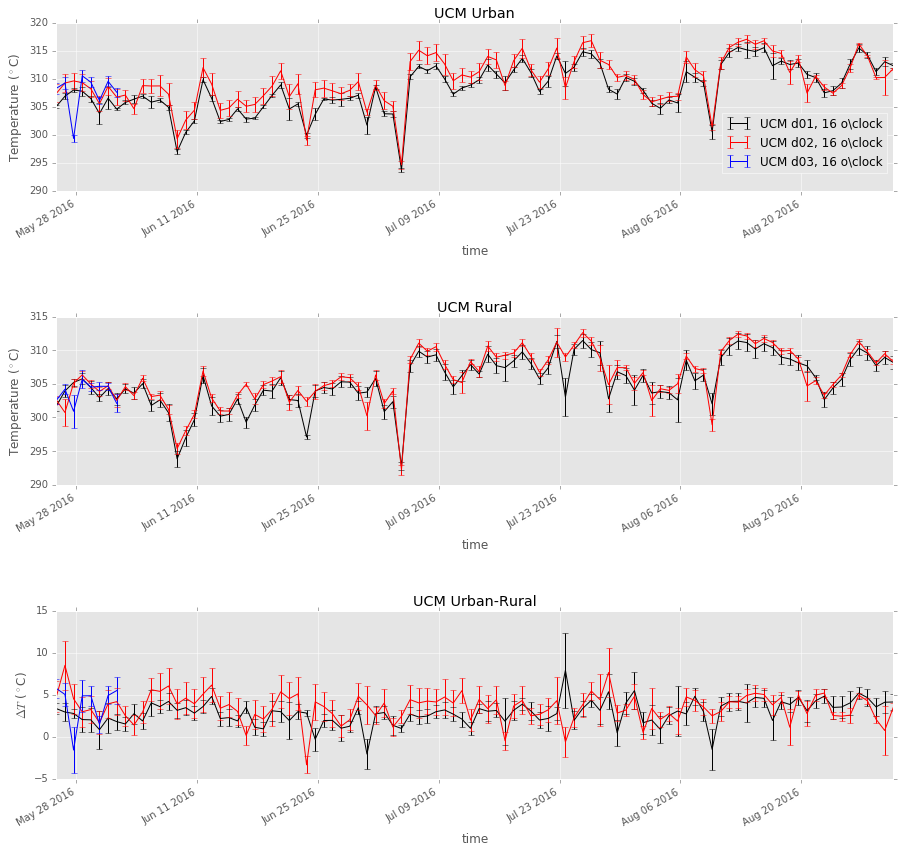

In [244]:
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
exp = 'UCM'
urban_df = pd.read_csv('data/urban_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
urban_df['T2', 'mean'] = urban_df['T2', 'mean'].subtract(273.15)
urban_df.index = urban_df.index.set_levels([urban_df.index.levels[0], pd.to_datetime(urban_df.index.levels[1])])

rural_df = pd.read_csv('data/rural_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
rural_df['T2', 'mean'] = rural_df['T2', 'mean'].subtract(273.15)
rural_df.index = rural_df.index.set_levels([rural_df.index.levels[0], pd.to_datetime(rural_df.index.levels[1])])


uhi_df = pd.read_csv('data/uhi_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
uhi_df.index = uhi_df.index.set_levels([uhi_df.index.levels[0], pd.to_datetime(uhi_df.index.levels[1])])

# plot by time 
dom = 'd01' 
var = 'T2'
hr = 6
for var in ['T2', 'TSK']: 
    for hr in [6,16] : 
        fig = plt.figure(figsize = [15,15])
        for dom, linestyle, color in zip(['d01', 'd02', 'd03'], ['-', '-', '-'], ['k', 'red', 'blue']) : 
            ax = plt.subplot(3,1,1)
            urban_df.loc[dom, idx[var, 'mean']][urban_df.loc[dom, idx[var, 'mean']].index.hour == hr].plot(ax = ax, color = color, 
                                                                                                       yerr = urban_df.loc[dom, idx[var, 'std']][urban_df.loc[dom, idx[var, 'std']].index.hour == hr],
                                                                                                      linestyle = linestyle, 
                                                                                                      label = '%s %s, %s o\clock'%(exp,dom,hr))
            ax.set_title('%s Urban'%exp)
            ax.set_ylabel('Temperature ($^\circ$C)')
            ax = plt.subplot(3,1,2)
            rural_df.loc[dom, idx[var, 'mean']][rural_df.loc[dom, idx[var, 'mean']].index.hour == hr].plot(ax = ax, color = color,
                                                                                                   yerr = rural_df.loc[dom, idx[var, 'std']][rural_df.loc[dom, idx[var, 'std']].index.hour == hr],
                                                                                                  linestyle = linestyle, 
                                                                                                  label = '%s %s, %s o\clock'%(exp,dom,hr))

            ax.set_title('%s Rural'%exp)
            ax.set_ylabel('Temperature ($^\circ$C)') 
            ax = plt.subplot(3,1,3)

            uhi_df.loc[dom, idx[var, 'mean']][rural_df.loc[dom, idx[var, 'mean']].index.hour == hr].plot(ax = ax,  color = color,
                                                                                                   yerr = uhi_df.loc[dom, idx[var, 'std']][uhi_df.loc[dom, idx[var, 'std']].index.hour == hr],
                                                                                                  linestyle = linestyle, 
                                                                                                  label = '%s %s, %s o\clock'%(exp,dom,hr))

            ax.set_title('%s Urban-Rural'%exp)
            ax.set_ylabel('$\Delta T$ ($^\circ$C)')

        plt.subplot(3,1,1).legend(bbox_to_anchor=(1, .5) )
        plt.subplots_adjust(hspace=0.75)
        plt.savefig('plots/%s_%s_%s_selectedpts_timeseries.png'%(exp,var,hr))

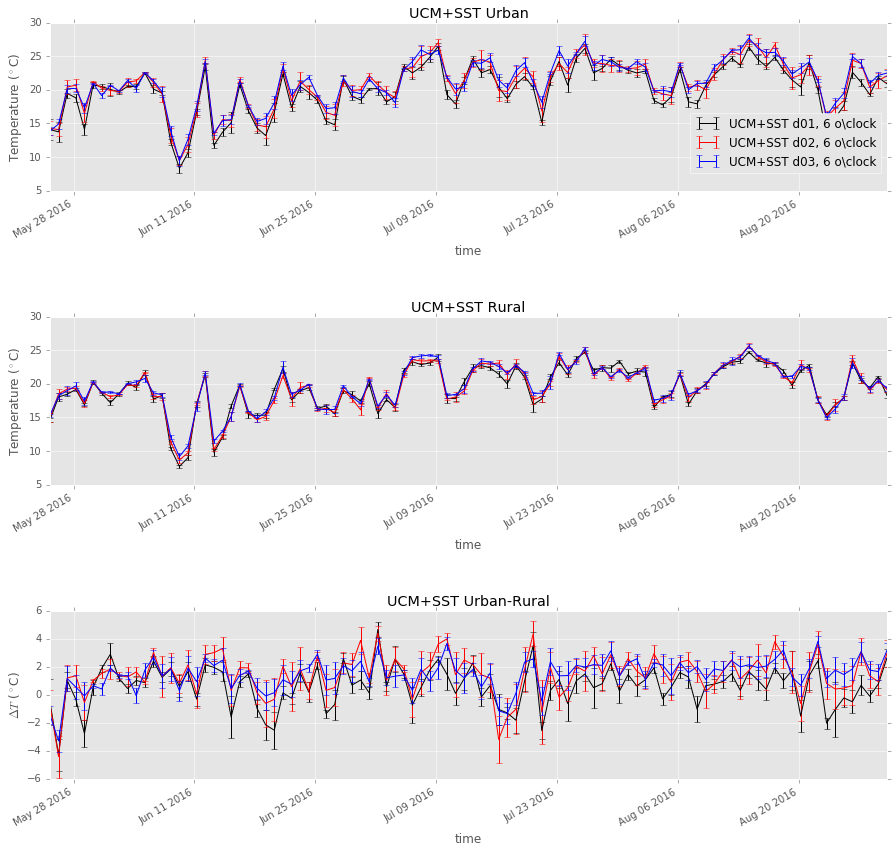

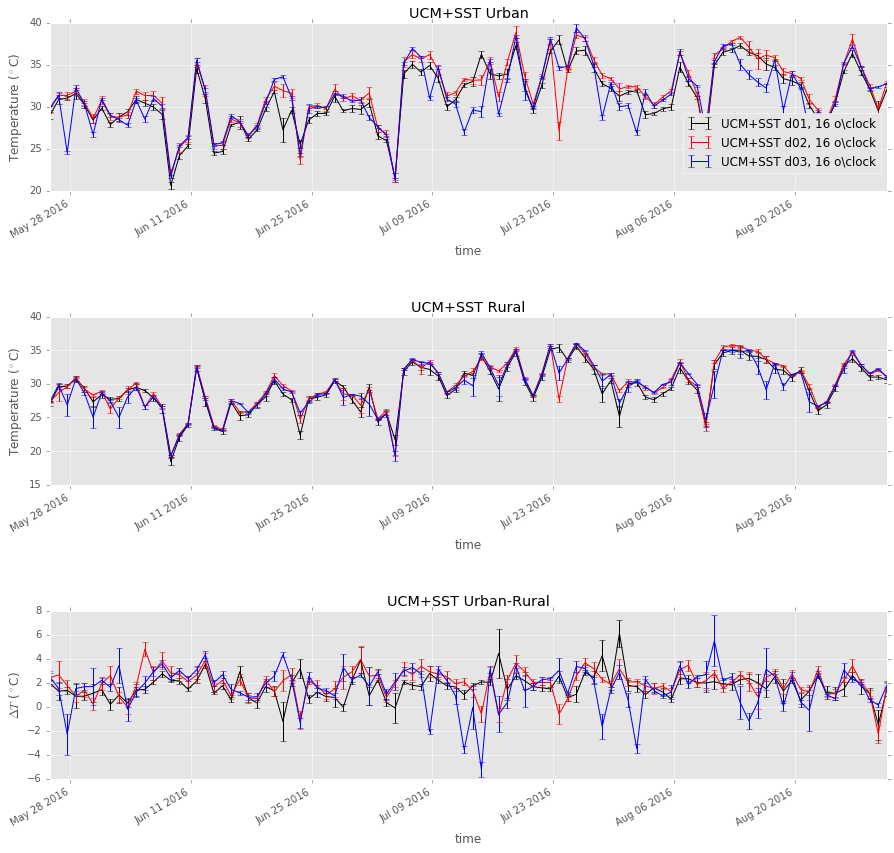

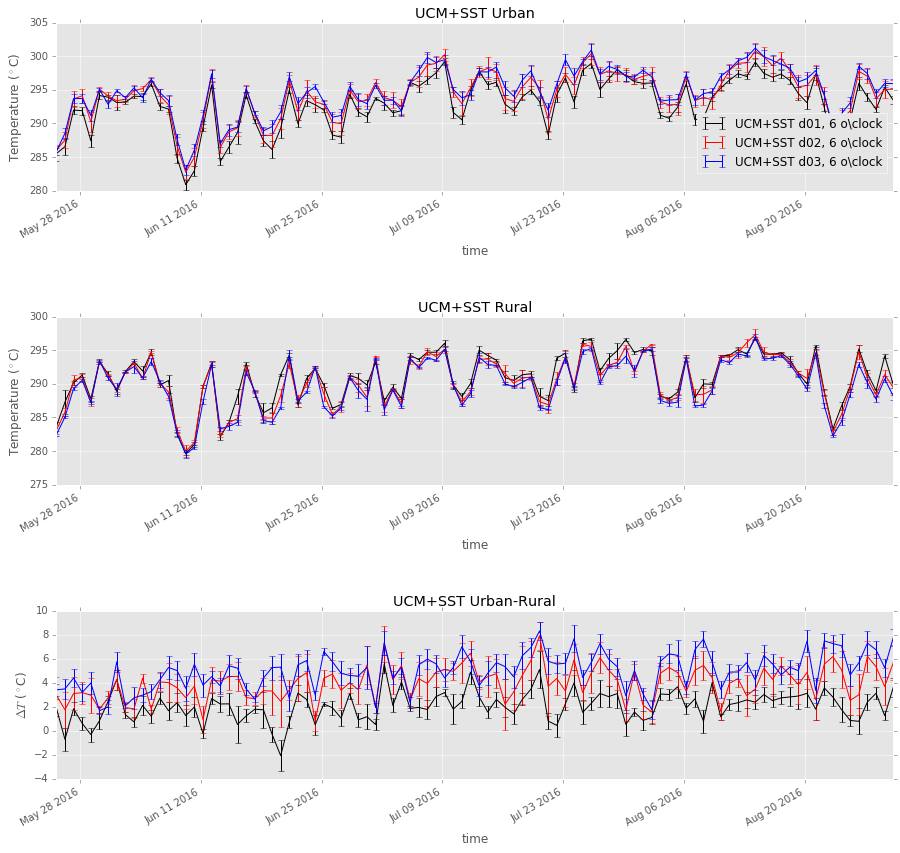

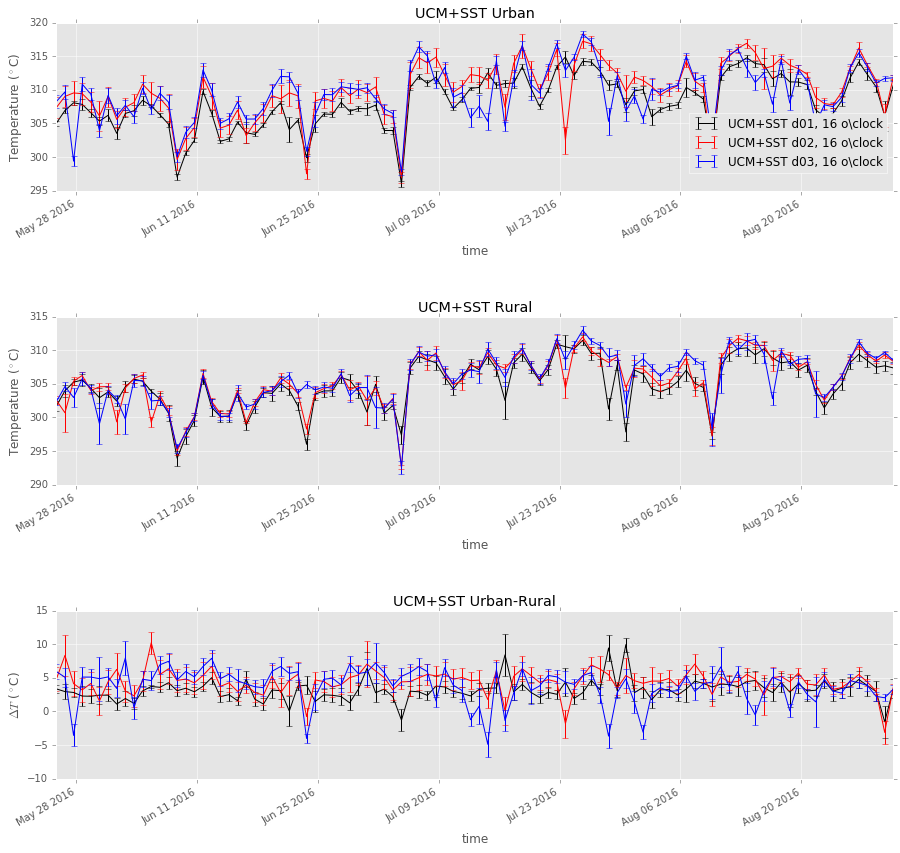

In [245]:
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
exp = 'UCM+SST'
urban_df = pd.read_csv('data/urban_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
urban_df['T2', 'mean'] = urban_df['T2', 'mean'].subtract(273.15)
urban_df.index = urban_df.index.set_levels([urban_df.index.levels[0], pd.to_datetime(urban_df.index.levels[1])])

rural_df = pd.read_csv('data/rural_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
rural_df['T2', 'mean'] = rural_df['T2', 'mean'].subtract(273.15)
rural_df.index = rural_df.index.set_levels([rural_df.index.levels[0], pd.to_datetime(rural_df.index.levels[1])])


uhi_df = pd.read_csv('data/uhi_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
uhi_df.index = uhi_df.index.set_levels([uhi_df.index.levels[0], pd.to_datetime(uhi_df.index.levels[1])])
# plot by time 
var = 'T2'
for var in ['T2', 'TSK']: 
    for hr in [6,16] : 
        fig = plt.figure(figsize = [15,15])
        for dom, linestyle, color in zip(['d01', 'd02', 'd03'], ['-', '-', '-'], ['k', 'red', 'blue']) : 
            ax = plt.subplot(3,1,1)
            urban_df.loc[dom, idx[var, 'mean']][urban_df.loc[dom, idx[var, 'mean']].index.hour == hr].plot(ax = ax, color = color, 
                                                                                                       yerr = urban_df.loc[dom, idx[var, 'std']][urban_df.loc[dom, idx[var, 'std']].index.hour == hr],
                                                                                                      linestyle = linestyle, 
                                                                                                      label = '%s %s, %s o\clock'%(exp,dom,hr))
            ax.set_title('%s Urban'%exp)
            ax.set_ylabel('Temperature ($^\circ$C)')
            ax = plt.subplot(3,1,2)
            rural_df.loc[dom, idx[var, 'mean']][rural_df.loc[dom, idx[var, 'mean']].index.hour == hr].plot(ax = ax, color = color,
                                                                                                   yerr = rural_df.loc[dom, idx[var, 'std']][rural_df.loc[dom, idx[var, 'std']].index.hour == hr],
                                                                                                  linestyle = linestyle, 
                                                                                                  label = '%s %s, %s o\clock'%(exp,dom,hr))

            ax.set_title('%s Rural'%exp)
            ax.set_ylabel('Temperature ($^\circ$C)') 
            ax = plt.subplot(3,1,3)

            uhi_df.loc[dom, idx[var, 'mean']][rural_df.loc[dom, idx[var, 'mean']].index.hour == hr].plot(ax = ax,  color = color,
                                                                                                   yerr = uhi_df.loc[dom, idx[var, 'std']][uhi_df.loc[dom, idx[var, 'std']].index.hour == hr],
                                                                                                  linestyle = linestyle, 
                                                                                                  label = '%s %s, %s o\clock'%(exp,dom,hr))

            ax.set_title('%s Urban-Rural'%exp)
            ax.set_ylabel('$\Delta T$ ($^\circ$C)')

        plt.subplot(3,1,1).legend(bbox_to_anchor=(1, .5) )
        plt.subplots_adjust(hspace=0.75)
        plt.savefig('plots/%s_%s_%s_selectedpts_timeseries.png'%(exp,var,hr))

In [255]:
var

'TSK'

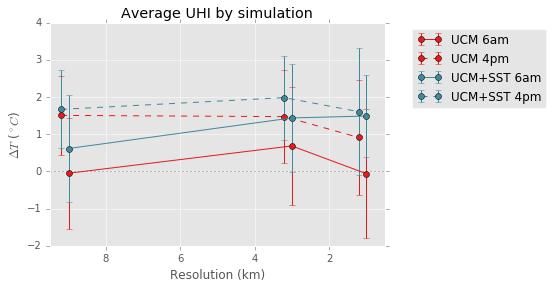

In [256]:
# now calculate UHI as a function of resolution, with error bars 

cmap = cm.get_cmap('Set1')
fig = plt.figure()
plt.axhline(0, color = 'gray', linestyle = ':')
var = 'T2'
i = 0
for exp in ['UCM', 'UCM+SST']: 
    uhi_df = pd.read_csv('data/uhi_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
    uhi_df.index = uhi_df.index.set_levels([uhi_df.index.levels[0], pd.to_datetime(uhi_df.index.levels[1])])

    color = cmap(i)
    hr = 6
    plt.errorbar([9,3,1] ,uhi_df.loc[uhi_df.index.get_level_values('time').hour == hr][var, 'mean'].mean(level = 0), 
             yerr = uhi_df.loc[uhi_df.index.get_level_values('time').hour == hr][var, 'mean'].std(level = 0),
             fmt ='-o', color = cmap(i), label = '%s 6am'%exp)
    hr = 16
    plt.errorbar([9.2,3.2,1.2] ,uhi_df.loc[uhi_df.index.get_level_values('time').hour == hr][var, 'mean'].mean(level = 0), 
                 yerr = uhi_df.loc[uhi_df.index.get_level_values('time').hour == hr][var, 'mean'].std(level = 0), 
            fmt = '--o',color = cmap(i),  label = '%s 4pm'%exp)
    i = i+40
    
plt.xlim([9.5, 0.5])
plt.xlabel('Resolution (km)')
plt.ylabel('$\Delta T$ ($^\circ C$)')
plt.legend(bbox_to_anchor=(1.5, 1),)
plt.title('Average UHI by simulation %s'%var)
plt.savefig('plots/UHI_by_resolution_errorbars.png', bbox_inches = 'tight')

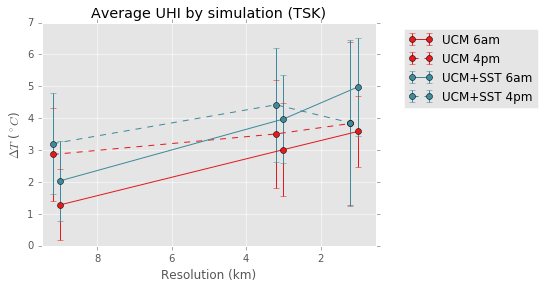

In [258]:
# now calculate UHI as a function of resolution, with error bars 

cmap = cm.get_cmap('Set1')
fig = plt.figure()
plt.axhline(0, color = 'gray', linestyle = ':')
var = 'TSK'
i = 0
for exp in ['UCM', 'UCM+SST']: 
    uhi_df = pd.read_csv('data/uhi_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True)
    uhi_df.index = uhi_df.index.set_levels([uhi_df.index.levels[0], pd.to_datetime(uhi_df.index.levels[1])])

    color = cmap(i)
    hr = 6
    plt.errorbar([9,3,1] ,uhi_df.loc[uhi_df.index.get_level_values('time').hour == hr][var, 'mean'].mean(level = 0), 
             yerr = uhi_df.loc[uhi_df.index.get_level_values('time').hour == hr][var, 'mean'].std(level = 0),
             fmt ='-o', color = cmap(i), label = '%s 6am'%exp)
    hr = 16
    plt.errorbar([9.2,3.2,1.2] ,uhi_df.loc[uhi_df.index.get_level_values('time').hour == hr][var, 'mean'].mean(level = 0), 
                 yerr = uhi_df.loc[uhi_df.index.get_level_values('time').hour == hr][var, 'mean'].std(level = 0), 
            fmt = '--o',color = cmap(i),  label = '%s 4pm'%exp)
    i = i+40
    
plt.xlim([9.5, 0.5])
plt.xlabel('Resolution (km)')
plt.ylabel('$\Delta T$ ($^\circ C$)')
plt.legend(bbox_to_anchor=(1.5, 1),)
plt.title('Average UHI by simulation (%s)'%var)
plt.savefig('plots/UHI_by_resolution_errorbars_%s.png'%var, bbox_inches = 'tight')

## Methodology
I've selected an urban and rural location corresponding to downtown Baltimore and directly north of Baltimore (near the Pennsylvania border). For each experiment's resolution, I've selected a three by three grid box and computed the average and standard deviation. I've plotted temperature over time for each experiment resolution (9,3,1 kms). 

Then, I've computed the UHI as a function of model resolution using the mean UHI calculated above. To compute error bars, I compute the standar deviation of the time series. Note that the highest resolution UCM only has a few data points compared to other runs. 

## Conclusions
-Nighttime or 6am  UHI does increase with increasing resolution 
-Increase happens mainly after 1st week 
-Daytime UHI increases for UCM, but decreases for UCM + SST
For 2-meter temperature: 
-increases are less, but still there

For Skin Temperature (TSK): 
-UCM at highest resolution still shows that 4pm UHI > 6am UHI, but only a couple of days
-UCM+SST shows that 4pm UHI < 6am UHI

# Feb 1: look at how UHI varies with model resolution

In [3]:
index = []
fpath = '/Users/ascott47/mountpoint/wrf/out/'
dirs = os.listdir(fpath)
for exp in dirs: 
    for dom in ['d01', 'd02','d03']: 
        files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
        if files: 
            print(exp,dom, " contains %i files"%len(files))
            index.append('%s_%s'%(exp,dom))

('UCM2D', 'd01', ' contains 2353 files')
('UCM2D', 'd02', ' contains 1449 files')
('UCM', 'd01', ' contains 2353 files')
('UCM', 'd02', ' contains 2353 files')
('UCM', 'd03', ' contains 196 files')
('UCM2D+SST', 'd01', ' contains 2353 files')
('UCM2D+SST', 'd02', ' contains 1447 files')
('UCM+SST', 'd01', ' contains 2353 files')
('UCM+SST', 'd02', ' contains 2353 files')
('UCM+SST', 'd03', ' contains 2353 files')


In [4]:
dirs = os.listdir('/Users/ascott47/mountpoint/wrf/run/2way/')
for exp in dirs: 
    for dom in ['d01', 'd02','d03']: 
        files = list(np.sort(glob.glob('/Users/ascott47/mountpoint/wrf/run/2way/%s/wrfout_%s*'%(exp,dom))))
        #files = list(np.sort(glob.glob('/Users/ascott47/mountpoint/wrf/run/%s/wrfout_%s*'%(exp,dom))))
        if files: 
            print(exp,dom, " contains %i files"%len(files))
            index.append('%s_%s'%(exp,dom))

('BEM2D+SST', 'd01', ' contains 61 files')
('BEM2D+SST', 'd02', ' contains 61 files')
('BEM2D+SST', 'd03', ' contains 61 files')


In [40]:
# cols = ['UHI_6am', 'UHI_4pm', 'UHI_max', 'UHI_min']
# uhidf = pd.DataFrame(index = index, columns=cols)
uhidf = pd.read_csv('uhi_analysis.csv').set_index('Unnamed: 0')
uhidf.loc['BEM2D+SST_d01'] = np.ones(uhidf.shape[1])*np.nan
uhidf.loc['BEM2D+SST_d02'] = np.ones(uhidf.shape[1])*np.nan
uhidf.loc['BEM2D+SST_d03'] = np.ones(uhidf.shape[1])*np.nan

In [7]:
analysis_points = meta.loc[[urban,rural]][['location:Longitude', 'location:Latitude']]
analysis_points = meta.loc[[urban,rural]][['location:Longitude', 'location:Latitude']]
analysis_points.index = ['urban', 'rural']
# pick a random rural point for analysis
analysis_points.loc['rural', 'location:Longitude'] = -76.752754
analysis_points.loc['rural', 'location:Latitude']  = 39.637964

('UCM2D', 'd01')
('UCM2D', 'd02')
('UCM2D', 'd03')
No data for UCM2D d03
('BEM2D+SST', 'd01')
No data for BEM2D+SST d01
('BEM2D+SST', 'd02')
No data for BEM2D+SST d02
('BEM2D+SST', 'd03')
No data for BEM2D+SST d03
('BEM2D', 'd01')
No data for BEM2D d01
('BEM2D', 'd02')
No data for BEM2D d02
('BEM2D', 'd03')
No data for BEM2D d03
('UCM', 'd01')
('UCM', 'd02')
('UCM', 'd03')
('BEM+SST', 'd01')
No data for BEM+SST d01
('BEM+SST', 'd02')
No data for BEM+SST d02
('BEM+SST', 'd03')
No data for BEM+SST d03
('BEM', 'd01')
No data for BEM d01
('BEM', 'd02')
No data for BEM d02
('BEM', 'd03')
No data for BEM d03
('UCM2D+SST', 'd01')
('UCM2D+SST', 'd02')
('UCM2D+SST', 'd03')
No data for UCM2D+SST d03
('UCM+SST', 'd01')
('UCM+SST', 'd02')
('UCM+SST', 'd03')


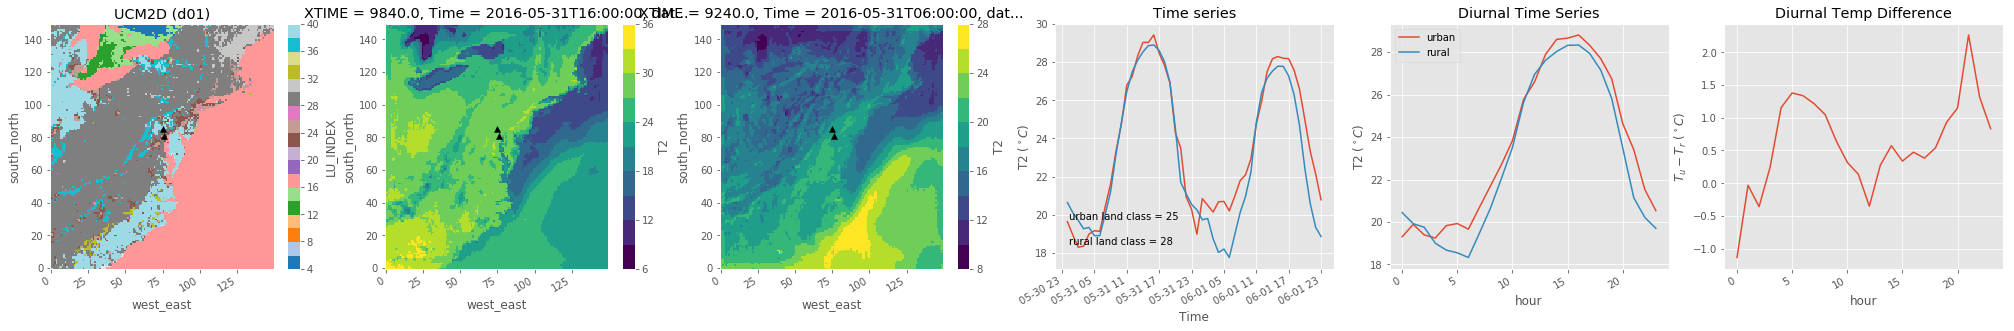

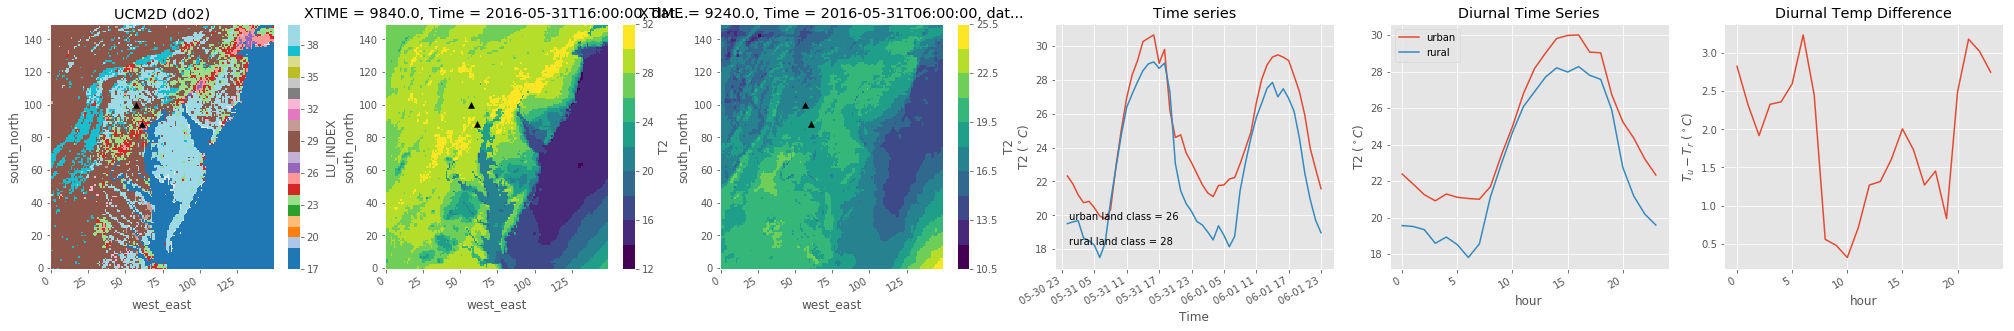

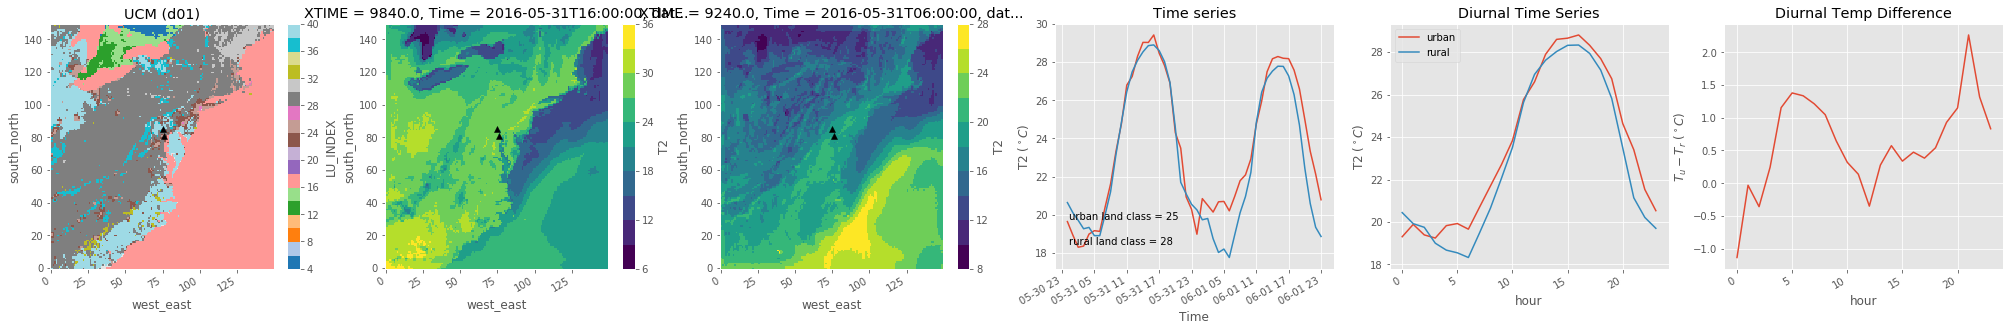

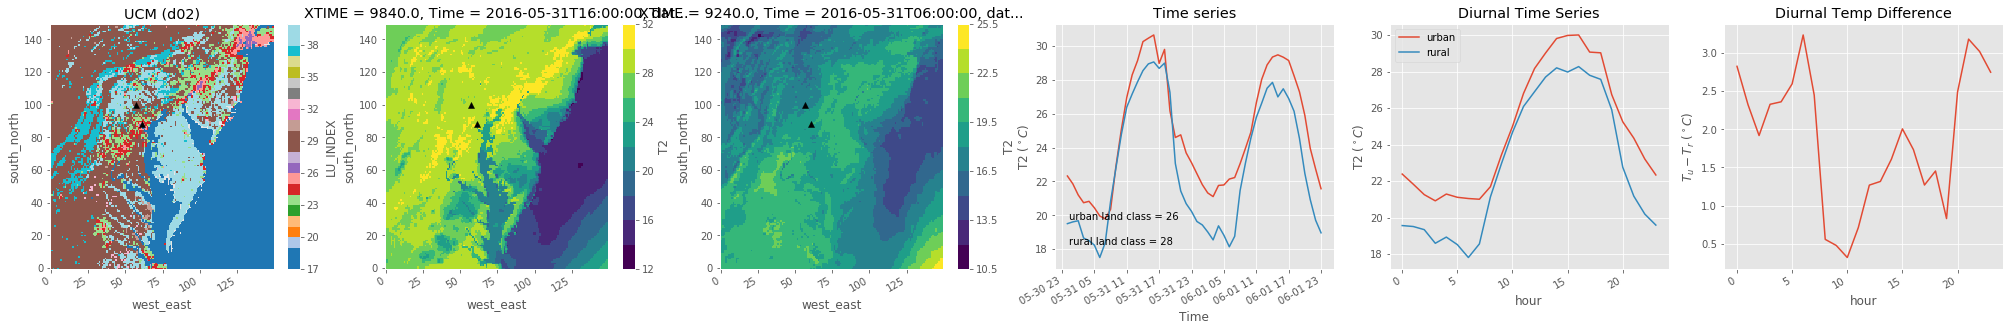

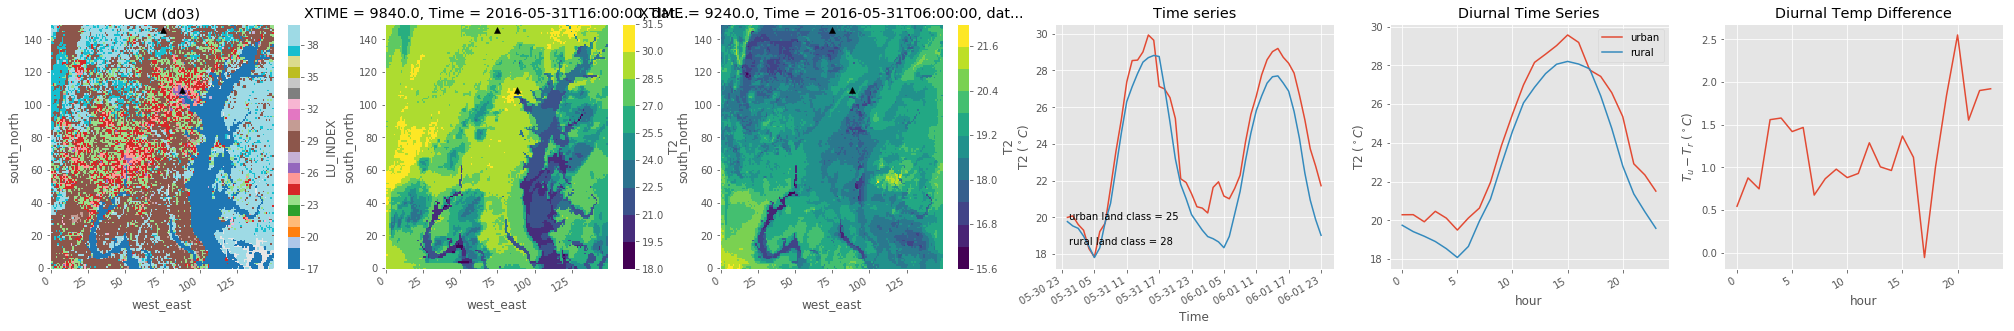

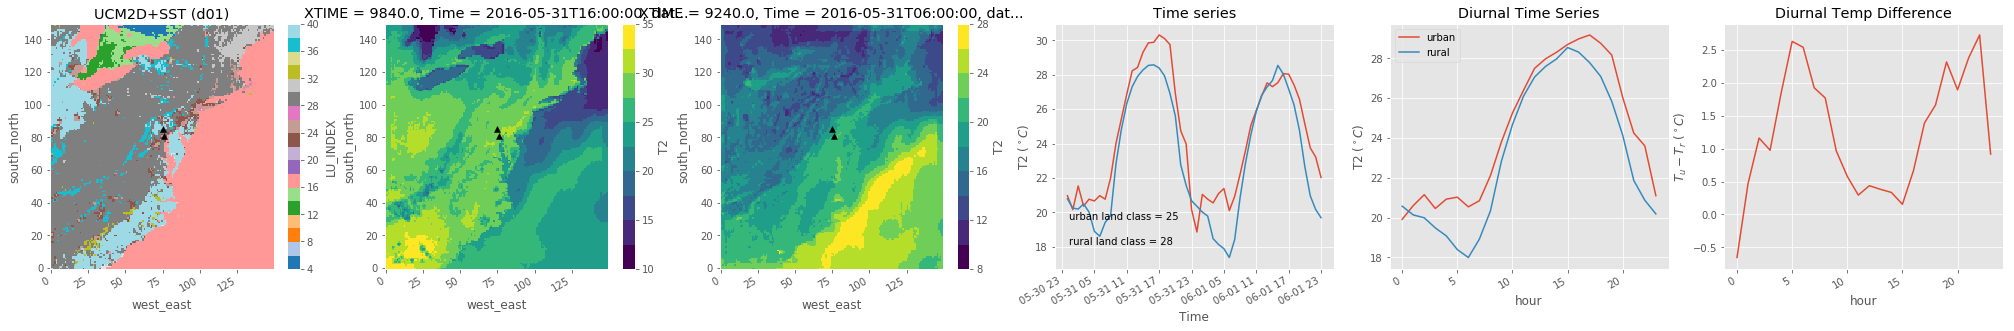

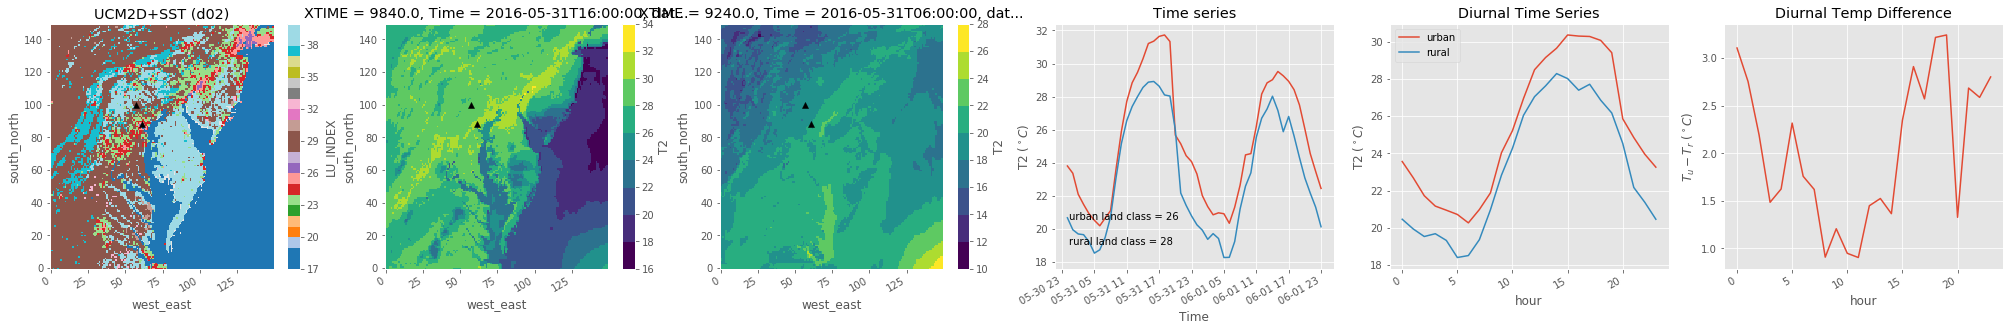

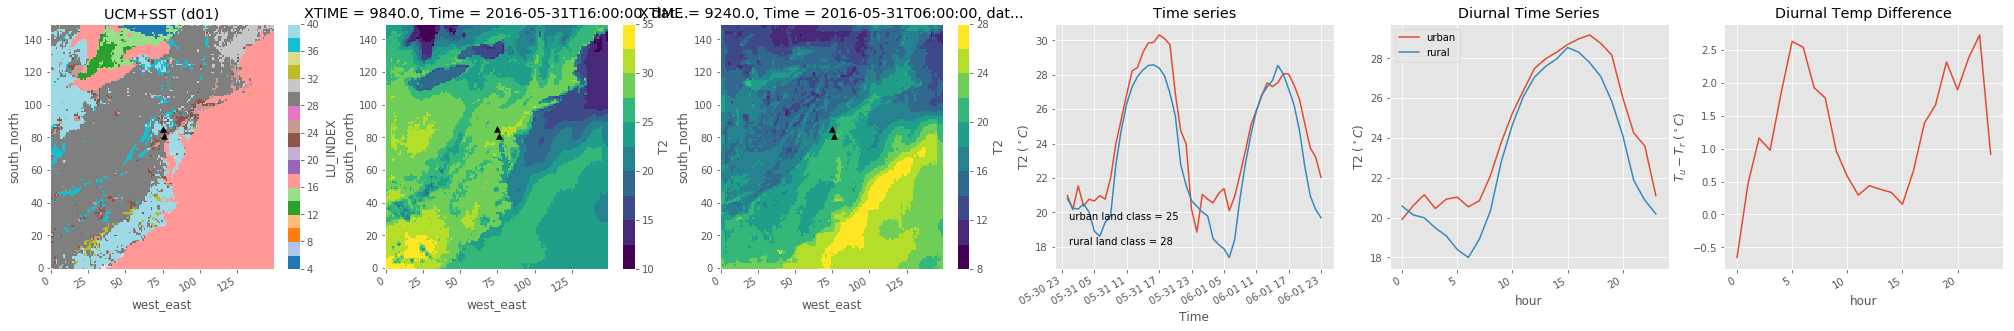

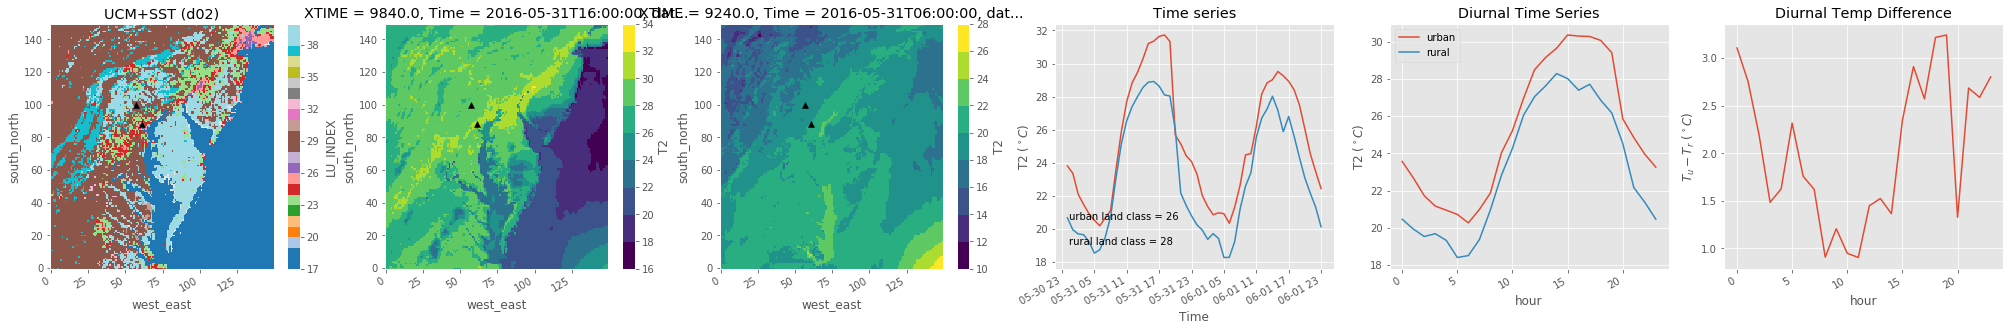

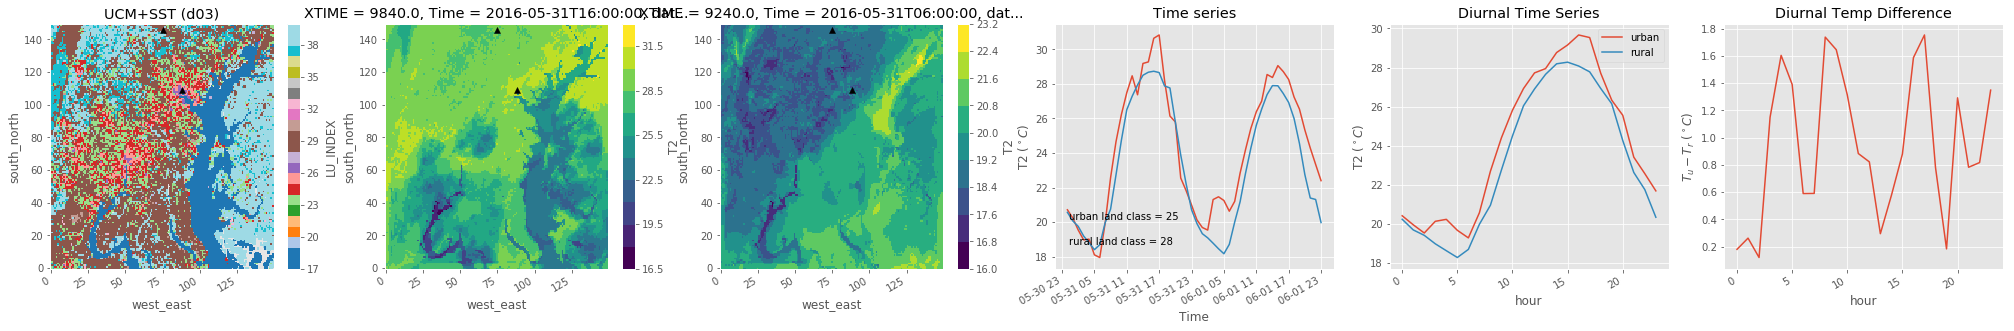

In [79]:
# loop 
fpath = '/Users/ascott47/mountpoint/wrf/out/'
dirs = os.listdir(fpath)
# dirs =  ['BEM2D+SST',
#  'BEM2D',
#  'UCM',
#  'BEM+SST',
#  'BEM',
#  'UCM2D+SST',
#  'UCM+SST']
date = '2016-05-31'
cols = ['UHI_6am', 'UHI_4pm', 'UHI_max', 'UHI_min', 'date']
uhidf = pd.DataFrame(index = index, columns=cols)

pts =pd.DataFrame([ [85,87],#west_east
                   [140, 109] ]) # south_north
for exp in dirs: 
    for dom in ['d01', 'd02','d03']: 
        #files = list(np.sort(glob.glob(fpath + '%s/wrfout_%s*'%(exp,dom))))
        files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))

        print(exp,dom)
        
        if files: 
            test_list = []
            for file in files[148:196]:
                test_list.append(Dataset(file))
            df = getvar(test_list, varname = "T2", 
                          timeidx = wrf.ALL_TIMES, 
                          method = 'cat'
                          )
            # convert to degrees C
            df = df - 273.15
            # convert to local time
            df['Time'] = df['Time'] - pd.Timedelta('04:00:00')
            # select analysis points
            points = wrf.ll_to_xy(Dataset(file), analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            pts = wrf.ll_to_xy(test_list[-1],analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            # points[0] is the lat coordinates
            # points[1] is the lon coordinate
            # urban, rural
            fig, axes = plt.subplots(ncols=6, figsize = [35,5])
            i = 0
            # plot landcover
            lc = getvar(test_list[-1], "LU_INDEX")
            # select analysis points
            points = wrf.ll_to_xy(Dataset(file), analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            pts = wrf.ll_to_xy(test_list[-1],analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            lc.plot(levels = 24, cmap  = cm.tab20, ax = axes[i])
            axes[i].set_title('%s (%s)'%(exp, dom))
            axes[i].scatter(pts.values[0], pts.values[1], marker = '^', color = 'k')
            i = i+1
            # make map day 
            try: 
                df.sel(Time = date +'T16:00:00').plot(ax = axes[i], levels = 11)
            except: 
                df.sel(Time = '2016-07-24' +'T16:00:00').plot(ax = axes[i], levels = 11)
            #axes[i].set_title('Night (%s 4am)'%date)
            axes[i].scatter(pts.values[0], pts.values[1], marker = '^', color = 'k')
            i = i+1
            # make map night 
            try: 
                df.sel(Time = date+'T6:00:00').plot(ax = axes[i], levels = 11)
            except: 
                df.sel(Time = '2016-07-24' +'T6:00:00').plot(ax = axes[i], levels = 11)
            axes[i].scatter(pts.values[0], pts.values[1], marker = '^', color = 'k')
            i = i+1
            # plot temp time series
    #         urban = df.isel(south_north= points.values[0][0], west_east = points.values[1][0])
    #         rural = df.isel(south_north= points.values[0][1], west_east = points.values[1][1])
            urban = df.isel(west_east = pts.values[0], south_north = pts.values[1])[:,0,0]
            rural = df.isel(west_east = pts.values[0], south_north = pts.values[1])[:,1,1]
            urban_lc = lc.isel(west_east = pts.values[0], south_north = pts.values[1])[0,0]
            rural_lc = lc.isel(west_east = pts.values[0], south_north = pts.values[1])[1,1]
            urban.plot(ax = axes[i])
            rural.plot(ax = axes[i])
            axes[i].set_title('Time series')
            axes[i].set_ylabel('T2 ($^\circ C$)')
            axes[i].annotate('urban land class = %i'%urban_lc,( .05,.2), xycoords = 'axes fraction')
            axes[i].annotate('rural land class = %i'%rural_lc,( .05,.1), xycoords = 'axes fraction')
            i = i+1
            # plot diurnal temp cycle
            urban.groupby('Time.hour').mean().plot(ax = axes[i], label = 'urban')
            rural.groupby('Time.hour').mean().plot(ax = axes[i], label = 'rural')
            axes[i].legend()
            axes[i].set_title('Diurnal Time Series')
            axes[i].set_ylabel('T2 ($^\circ C$)')
            i = i+1
            # plot DT in time
            (urban-rural).groupby('Time.hour').mean().plot(ax = axes[i])
            axes[i].set_ylabel('$T_u - T_r$ ($^\circ C$)')
            axes[i].set_title('Diurnal Temp Difference')
            plt.savefig('figures/UHIbyExp/1waynest%s%s.png'%(exp, dom))
            
            uhi = (urban-rural).groupby('Time.hour').mean()
            uhidf.loc['%s_%s'%(exp,dom)]['UHI_6am'] =  uhi.sel(hour = 6).to_pandas()
            uhidf.loc['%s_%s'%(exp,dom)]['UHI_4pm'] =  uhi.sel(hour = 16).to_pandas()
            uhidf.loc['%s_%s'%(exp,dom)]['UHI_max'] =  uhi.max().to_pandas()
            uhidf.loc['%s_%s'%(exp,dom)]['UHI_min'] =  uhi.min().to_pandas()
            uhidf.loc['%s_%s'%(exp,dom)]['date'] =  df.Time[0].to_pandas()
            
            df.close()
        else:  
            print('No data for %s %s'%(exp, dom))
uhidf.to_csv('uhi_analysis.csv')

In [122]:
uhidf

UHI_6am         UHI_4pm        UHI_max  \
UCM2D_d01       1.33464050293  0.473342895508   2.2635345459   
UCM2D_d02       3.23080444336   1.73168945312  3.23080444336   
UCM_d01         1.33464050293  0.473342895508   2.2635345459   
UCM_d02         3.23080444336   1.73168945312  3.23080444336   
UCM_d03         1.46629333496   1.11645507812  2.54983520508   
UCM2D+SST_d01   2.54345703125  0.664169311523  2.73092651367   
UCM2D+SST_d02   1.75708007812   2.90841674805  3.24038696289   
UCM+SST_d01     2.54345703125  0.664169311523  2.73092651367   
UCM+SST_d02     1.75708007812   2.90841674805  3.24038696289   
UCM+SST_d03    0.589202880859   1.58712768555  1.75347900391   

                        UHI_min                           date  resolution  
UCM2D_d01         -1.1353302002  2016-05-31T00:00:00.000000000         5.0  
UCM2D_d02        0.322219848633  2016-05-31T00:00:00.000000000         3.0  
UCM_d01           -1.1353302002  2016-05-31T00:00:00.000000000         5.0  
UCM_d02          0.322219848633  2016-05-31T00:00:00.000000000         3.0  
UCM_d03        -0.0575561523438  2016-05-31T00:00:00.000000000         1.0  
UCM2D+SST_d01   -0.657089233398  2016-05-31T00:00:00.000000000         5.0  
UCM2D+SST_d02    0.904769897461  2016-05-31T00:00:00.000000000         3.0  
UCM+SST_d01     -0.657089233398  2016-05-31T00:00:00.000000000         5.0  
UCM+SST_d02      0.904769897461  2016-05-31T00:00:00.000000000         3.0  
UCM+SST_d03      0.119476318359  2016-05-31T00:00:00.000000000         1.0

In [29]:
uhidf['resolution'] =np.ones(uhidf.shape[0])*np.nan
uhidf['exp'] =np.ones(uhidf.shape[0])*np.nan

res_dict = {'d01' :9,'d02': 3, 'd03': 1}
for ind in uhidf.index: 
    uhidf.loc[ind,'resolution'] = res_dict[ind[-3:]]
    uhidf.loc[ind,'exp'] = ind[:-4]

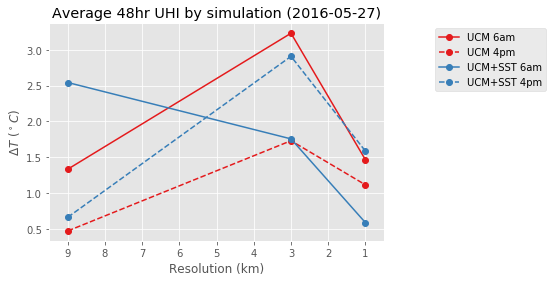

In [31]:
cmap = cm.get_cmap('Set1')
fig = plt.figure()
i = 0
for exp in ['UCM', 'UCM+SST']: 
    color = cmap(i)
    plt.plot(uhidf[uhidf['exp']==exp].resolution.values, uhidf[uhidf['exp']==exp].UHI_6am.values, 
            '-o', color = color, label = '%s 6am'%exp)
    plt.plot(uhidf[uhidf['exp']==exp].resolution.values, uhidf[uhidf['exp']==exp].UHI_4pm.values, 
            '--o',color = color,  label = '%s 4pm'%exp)
    i = i+1
plt.xlim([9.5, 0.5])
plt.xlabel('Resolution (km)')
plt.ylabel('$\Delta T$ ($^\circ C$)')
plt.legend(bbox_to_anchor=(1.5, 1),)
plt.title('Average 48hr UHI by simulation (%s)'%date)

We looked at the following experiments: 
UCM2D d01  contains 906 files
BEM2D+SST d01  contains 48 files
BEM2D+SST d02  contains 48 files
BEM2D+SST d03  contains 48 files
UCM2D+SST d01  contains 906 files

We compare BEM on May 25 with UCM on July 24 and see that: 

- UCM reproduces nighttime urban heating better than BEM2d
- UCM UHI intensities are highter than for BEM, even at a lower resolution
- Increasing resolution for BEM slightly decreases the daytime UHI intensity (prob. not significantly different, though)
- BEM shows negative UHI at 5 and 6 am ($T_r > T_u$)

('BEM2D+SST', 'd01')
('BEM2D+SST', 'd02')
('BEM2D+SST', 'd03')
('BEM2D', 'd01')
No data for BEM2D
('BEM2D', 'd02')
No data for BEM2D
('BEM2D', 'd03')
No data for BEM2D
('BEM+SST', 'd01')
No data for BEM+SST
('BEM+SST', 'd02')
No data for BEM+SST
('BEM+SST', 'd03')
No data for BEM+SST
('BEM', 'd01')
No data for BEM
('BEM', 'd02')
No data for BEM
('BEM', 'd03')
No data for BEM


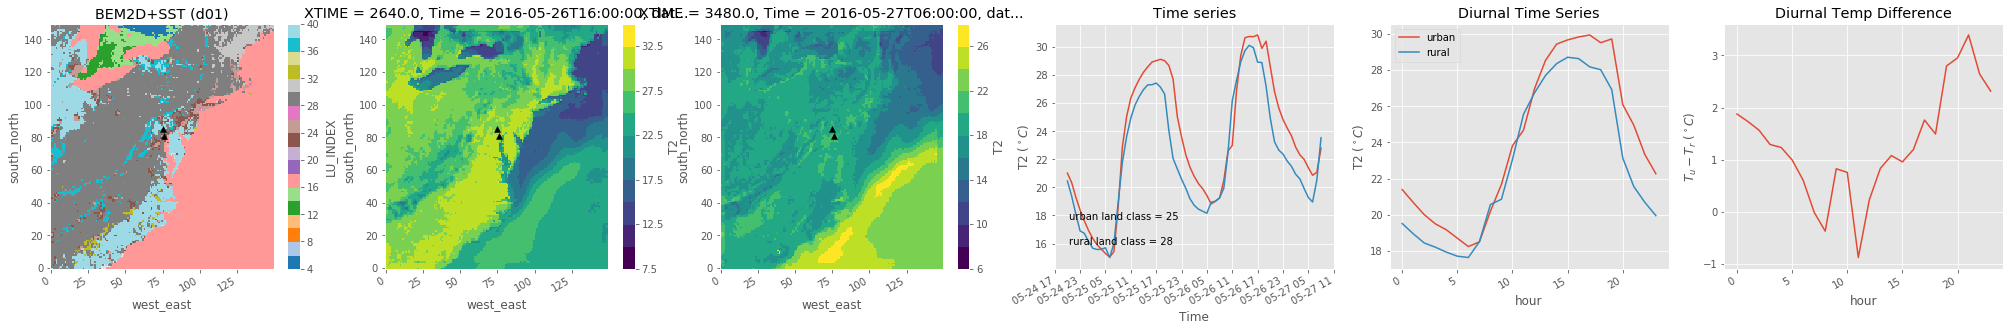

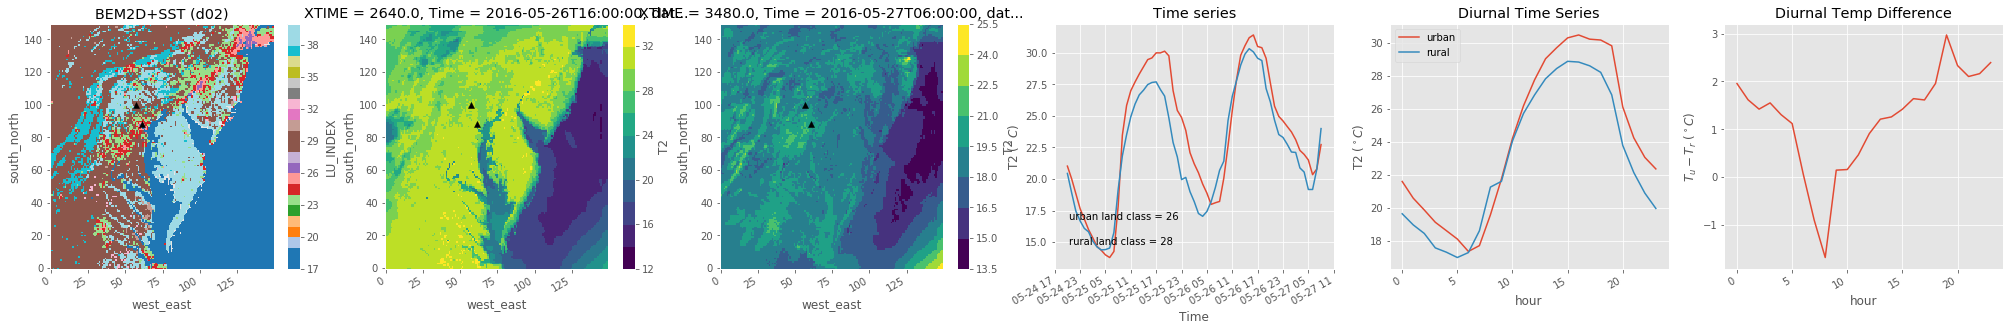

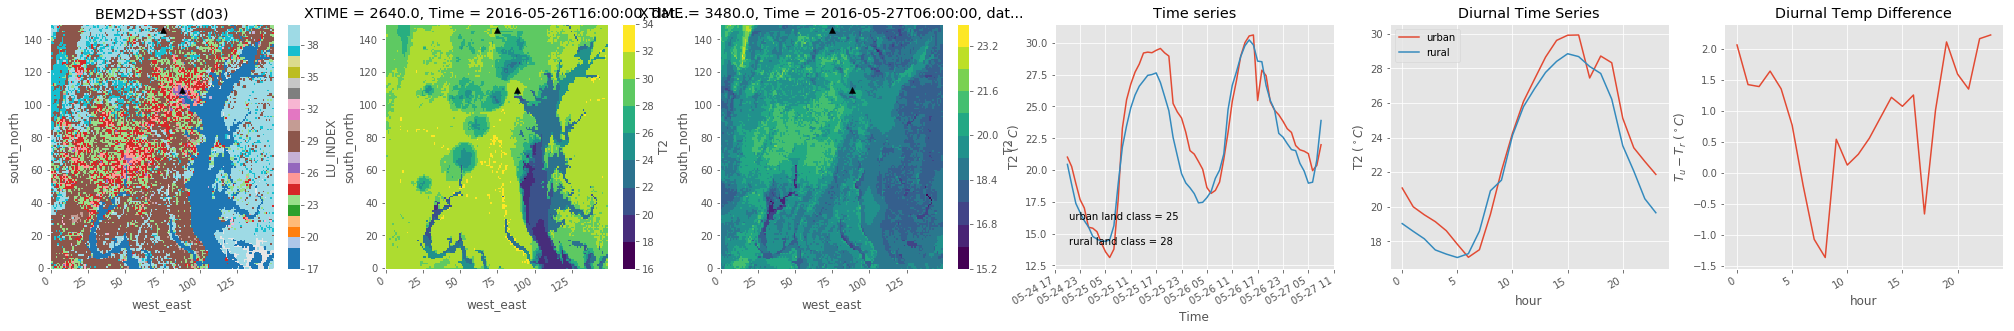

In [15]:
# do the same for 2 way nesting
dirs = os.listdir('/Users/ascott47/mountpoint/wrf/run/2way/')
#dom = 'd03'
date = '2016-05-27' 
# pts =pd.DataFrame([ [85,87],#west_east
#                    [140, 109] ]) # south_north
# rural analysis points; south_north = 140, west_east = 85
# urban analysis points: south_north = 109, west_east = 87])
for exp in dirs: 
    for dom in ['d01', 'd02','d03']: 
        print(exp, dom)
        files = list(np.sort(glob.glob('/Users/ascott47/mountpoint/wrf/run/2way/%s/wrfout_%s*'%(exp,dom))))
        if files:
        #files = list(np.sort(glob.glob(fpath+'%s/d01/wrfout_*'%exp)))
                # open dataset
            test_list = []
            for file in files:
                test_list.append(Dataset(file))
            df = getvar(test_list, varname = "T2", 
                          timeidx = wrf.ALL_TIMES, 
                          method = 'cat'
                          )
            # convert to degrees C
            df = df - 273.15
            # convert to local time
            df['Time'] = df['Time'] - pd.Timedelta('04:00:00')
            # select analysis points
            points = wrf.ll_to_xy(Dataset(file), analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            pts = wrf.ll_to_xy(test_list[-1],analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            # points[0] is the lat coordinates
            # points[1] is the lon coordinate
            # urban, rural
            fig, axes = plt.subplots(ncols=6, figsize = [35,5])
            i = 0
            # plot landcover
            lc = getvar(test_list[-1], "LU_INDEX")
            lc.plot(levels = 24, cmap  = cm.tab20, ax = axes[i])
            axes[i].set_title('%s (%s)'%(exp, dom))
            axes[i].scatter(pts.values[0], pts.values[1], marker = '^', color = 'k')
            i = i+1
            # make map day 
            try: 
                df.sel(Time = date +'T16:00:00').plot(ax = axes[i], levels = 11)
            except: 
                df.sel(Time = '2016-05-26' +'T16:00:00').plot(ax = axes[i], levels = 11)
            #axes[i].set_title('Night (%s 4am)'%date)
            axes[i].scatter(pts.values[0], pts.values[1], marker = '^', color = 'k')
            i = i+1
            # make map night 
            df.sel(Time = date+'T6:00:00').plot(ax = axes[i], levels = 11)

            axes[i].scatter(pts.values[0], pts.values[1], marker = '^', color = 'k')
            i = i+1
            # plot temp time series
    #         urban = df.isel(south_north= points.values[0][0], west_east = points.values[1][0])
    #         rural = df.isel(south_north= points.values[0][1], west_east = points.values[1][1])
            urban = df.isel(west_east = pts.values[0], south_north = pts.values[1])[:,0,0]
            rural = df.isel(west_east = pts.values[0], south_north = pts.values[1])[:,1,1]
            urban_lc = lc.isel(west_east = pts.values[0], south_north = pts.values[1])[0,0]
            rural_lc = lc.isel(west_east = pts.values[0], south_north = pts.values[1])[1,1]
            urban.plot(ax = axes[i])
            rural.plot(ax = axes[i])
            axes[i].set_title('Time series')
            axes[i].set_ylabel('T2 ($^\circ C$)')
            axes[i].annotate('urban land class = %i'%urban_lc,( .05,.2), xycoords = 'axes fraction')
            axes[i].annotate('rural land class = %i'%rural_lc,( .05,.1), xycoords = 'axes fraction')
            i = i+1
            # plot diurnal temp cycle
            urban.groupby('Time.hour').mean().plot(ax = axes[i], label = 'urban')
            rural.groupby('Time.hour').mean().plot(ax = axes[i], label = 'rural')
            axes[i].legend()
            axes[i].set_title('Diurnal Time Series')
            axes[i].set_ylabel('T2 ($^\circ C$)')
            i = i+1
            # plot DT in time
            (urban-rural).groupby('Time.hour').mean().plot(ax = axes[i])
            axes[i].set_ylabel('$T_u - T_r$ ($^\circ C$)')
            axes[i].set_title('Diurnal Temp Difference')
            
            uhi = (urban-rural).groupby('Time.hour').mean()
            uhidf.loc['%s_%s'%(exp,dom),'UHI_6am'] =  uhi.sel(hour = 6).to_pandas()
            uhidf.loc['%s_%s'%(exp,dom),'UHI_4pm'] =  uhi.sel(hour = 16).to_pandas()
            uhidf.loc['%s_%s'%(exp,dom),'UHI_max'] =  uhi.max().to_pandas()
            uhidf.loc['%s_%s'%(exp,dom),'UHI_min'] =  uhi.min().to_pandas()
            uhidf.loc['%s_%s'%(exp,dom),'date'] =  df.Time[0].to_pandas()
            plt.savefig('figures/UHIbyExp/2waynest%s%s.png'%(exp, dom))
            
            df.close()
        else:  
            print('No data for %s'%exp)

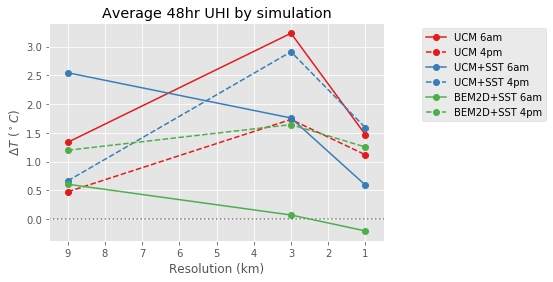

In [38]:
cmap = cm.get_cmap('Set1')
fig = plt.figure()
plt.axhline(0, color = 'gray', linestyle = ':')

i = 0
for exp in ['UCM', 'UCM+SST', 'BEM2D+SST']:#uhidf.exp.unique():#['UCM', 'UCM+SST']: 
    color = cmap(i)
    plt.plot(uhidf[uhidf['exp']==exp].resolution.values, uhidf[uhidf['exp']==exp].UHI_6am.values, 
            '-o', color = color, label = '%s 6am'%exp)
    plt.plot(uhidf[uhidf['exp']==exp].resolution.values, uhidf[uhidf['exp']==exp].UHI_4pm.values, 
            '--o',color = color,  label = '%s 4pm'%exp)
    i = i+1
plt.xlim([9.5, 0.5])
plt.xlabel('Resolution (km)')
plt.ylabel('$\Delta T$ ($^\circ C$)')
plt.legend(bbox_to_anchor=(1.5, 1),)
plt.title('Average 48hr UHI by simulation')
plt.savefig('plots/UHI_by_resolution.png', bbox_to_anchor = 'tight')

In [36]:
uhidf.head()

UHI_6am   UHI_4pm   UHI_max   UHI_min  \
Unnamed: 0                                           
UCM2D_d01   1.334641  0.473343  2.263535 -1.135330   
UCM2D_d02   3.230804  1.731689  3.230804  0.322220   
UCM_d01     1.334641  0.473343  2.263535 -1.135330   
UCM_d02     3.230804  1.731689  3.230804  0.322220   
UCM_d03     1.466293  1.116455  2.549835 -0.057556   

                                     date  resolution    exp  
Unnamed: 0                                                    
UCM2D_d01   2016-05-31T00:00:00.000000000         9.0  UCM2D  
UCM2D_d02   2016-05-31T00:00:00.000000000         3.0  UCM2D  
UCM_d01     2016-05-31T00:00:00.000000000         9.0    UCM  
UCM_d02     2016-05-31T00:00:00.000000000         3.0    UCM  
UCM_d03     2016-05-31T00:00:00.000000000         1.0    UCM

# Methodology 
I fixed a latitude and longitude point to represent the urban and rural location. For each run, I read in the landcover class and 2-meter temperature at that point for a 48 hour period (May 31-June 1 for one-way nested runs, May 25-27 for the two-way nested runs). I looked at the diurnal temperature cycle and then calculated the average UHI $T_u - T_r$ for that 48 hour period. Then, I looked at how UHI varies by resolution for UCM, UCM + SST, and BEM2D + SST runs. 

I briefly assessed the sensitivity of these findings to individual dates and didn't find dates where this was true. 


# Conclusions
In order to investigate how urban simulations capture Baltimore's UHI, we looked at the following experiments: 
UCM2D d01  contains 906 files
BEM2D+SST d01  contains 48 files
BEM2D+SST d02  contains 48 files
BEM2D+SST d03  contains 48 files
UCM2D+SST d01  contains 906 files


# One-way nesting

We compare BEM on May 25 with UCM on May 31 and see that: 

- UCM reproduces nighttime urban heating better than BEM2d
- UCM UHI intensities are highter than for BEM, even at a lower resolution
- Increasing resolution for BEM slightly decreases the daytime UHI intensity (prob. not significantly different, though)
- BEM shows negative UHI at 5 and 6 am ($T_r > T_u$)

# Two-way nesting
- The model reproduces daytime heating, but no nighttime UHI. 
- Increasing resolution changes the timing of the UHI diurnal cycle, buty has little impact on magitude
- In higher resolution runs, urban $T_{min}$ occurs later in the day than rural $T_{min}$

Highest UHI is for UCM2D+SST, which has $\Delta T_{min} = 3.5$ and $\Delta T_{max} = 4.5$ 

# Overall 
These simulations do not reproduce the phenomena of UHI being warmer at night. Only UCM runs (without SST update) show that UHI is greater at 6am than at 4pm. UHI increases for the 3 km runs, but decreases for the 1 km runs. 